## 1. Libraries 📖

In [2]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [14]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [3]:
df_train = pd.read_csv("../../data/train/caco/caco_maccs_train.csv")
df_test = pd.read_csv("../../data/train/caco/caco_maccs_test.csv")
df_valid = pd.read_csv("../../data/train/caco/caco_maccs_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'permeability']
y_train_all = df_train_all['permeability']

X_train = df_train_all.loc[:, df_train_all.columns != 'permeability']
y_train = df_train_all['permeability']

X_test = df_test.loc[:, df_test.columns != 'permeability']
y_test = df_test['permeability']

X_valid = df_valid.loc[:, df_valid.columns != 'permeability']
y_valid = df_valid['permeability']

In [5]:
X_train.shape

(2811, 166)

In [6]:
X_test.shape

(704, 166)

In [7]:
X_valid.shape

(351, 166)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [8]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(166, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [31]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [32]:
best_value = 1000
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=351, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 839.1340956254439, Accuracy: -0.16394814016687528
Test Avg. loss: 727.3736572265625, Accuracy: 0.21315126403678375
################## EPOCH 2 ##################
Train Avg. loss: 773.5310017845848, Accuracy: -0.1587592515329325
Test Avg. loss: 642.2717895507812, Accuracy: 0.30521159499034045
################## EPOCH 3 ##################
Train Avg. loss: 725.8691165230491, Accuracy: -0.18443007012547163
Test Avg. loss: 645.8709716796875, Accuracy: 0.3013181100691974
################## EPOCH 4 ##################
Train Avg. loss: 691.9720555218784, Accuracy: -0.14606792303029625
Test Avg. loss: 510.38372802734375, Accuracy: 0.4478837451488511
################## EPOCH 5 ##################
Train Avg. loss: 661.5861573652787, Accuracy: -0.19186944473702727
Test Avg. loss: 492.1648864746094, Accuracy: 0.46759229679060643
################## EPOCH 6 ##################
Train Avg. loss: 645.3915455558083,

Train Avg. loss: 350.78483217412776, Accuracy: 0.17527716965989645
Test Avg. loss: 275.2692565917969, Accuracy: 0.7022228065979021
################## EPOCH 48 ##################
Train Avg. loss: 313.4644662250172, Accuracy: 0.34493353949106836
Test Avg. loss: 244.8856658935547, Accuracy: 0.7350907885854489
################## EPOCH 49 ##################
Train Avg. loss: 316.09049064462835, Accuracy: 0.2997924783492934
Test Avg. loss: 271.9388427734375, Accuracy: 0.7058255452918438
################## EPOCH 50 ##################
Train Avg. loss: 327.021073254672, Accuracy: 0.3262494810811474
Test Avg. loss: 250.05459594726562, Accuracy: 0.7294991924467928
################## EPOCH 51 ##################
Train Avg. loss: 392.5746818889271, Accuracy: 0.1662695069080136
Test Avg. loss: 195.16085815429688, Accuracy: 0.7888814218367401
################## EPOCH 52 ##################
Train Avg. loss: 318.2691319205544, Accuracy: 0.29744015031148796
Test Avg. loss: 248.58348083496094, Accuracy: 0.7

Train Avg. loss: 243.27154510671443, Accuracy: 0.5032576216503517
Test Avg. loss: 192.98077392578125, Accuracy: 0.7912397748029478
################## EPOCH 95 ##################
Train Avg. loss: 249.2496509552002, Accuracy: 0.4718136007910634
Test Avg. loss: 199.89578247070312, Accuracy: 0.7837593370385606
################## EPOCH 96 ##################
Train Avg. loss: 268.61089593713933, Accuracy: 0.363912025022243
Test Avg. loss: 178.16400146484375, Accuracy: 0.8072680602256024
################## EPOCH 97 ##################
Train Avg. loss: 262.92785839601, Accuracy: 0.4749484052393982
Test Avg. loss: 217.23268127441406, Accuracy: 0.7650048677628956
################## EPOCH 98 ##################
Train Avg. loss: 249.64282608032227, Accuracy: 0.46020558263929257
Test Avg. loss: 220.02761840820312, Accuracy: 0.7619813851271169
################## EPOCH 99 ##################
Train Avg. loss: 228.89075274900958, Accuracy: 0.44993055684612543
Test Avg. loss: 209.03775024414062, Accuracy: 0

Train Avg. loss: 201.24998231367633, Accuracy: 0.5704144155755406
Test Avg. loss: 205.44989013671875, Accuracy: 0.7777510889830891
################## EPOCH 142 ##################
Train Avg. loss: 200.41999556801537, Accuracy: 0.5448660924588729
Test Avg. loss: 157.10708618164062, Accuracy: 0.8300467554150861
################## EPOCH 143 ##################
Train Avg. loss: 211.12802076339722, Accuracy: 0.5622685538692114
Test Avg. loss: 170.8356475830078, Accuracy: 0.8151956328573553
################## EPOCH 144 ##################
Train Avg. loss: 216.02694498408925, Accuracy: 0.5792280709968014
Test Avg. loss: 192.411865234375, Accuracy: 0.7918552121917405
################## EPOCH 145 ##################
Train Avg. loss: 183.31087758324364, Accuracy: 0.5881256611779173
Test Avg. loss: 178.06610107421875, Accuracy: 0.8073739613599606
################## EPOCH 146 ##################
Train Avg. loss: 192.61532371694392, Accuracy: 0.5747175478883891
Test Avg. loss: 201.6844024658203, Accurac

Train Avg. loss: 209.12182812257245, Accuracy: 0.5701985004512449
Test Avg. loss: 228.33534240722656, Accuracy: 0.7529943732935608
################## EPOCH 189 ##################
Train Avg. loss: 197.41798080097544, Accuracy: 0.5565219517079804
Test Avg. loss: 168.82806396484375, Accuracy: 0.81736737980126
################## EPOCH 190 ##################
Train Avg. loss: 215.6656170758334, Accuracy: 0.5880065853524766
Test Avg. loss: 243.47024536132812, Accuracy: 0.7366219286984597
################## EPOCH 191 ##################
Train Avg. loss: 168.1984382976185, Accuracy: 0.6139604141363062
Test Avg. loss: 196.38082885742188, Accuracy: 0.7875616864918323
################## EPOCH 192 ##################
Train Avg. loss: 183.38493832674894, Accuracy: 0.6219542486887184
Test Avg. loss: 178.20584106445312, Accuracy: 0.8072228005984641
################## EPOCH 193 ##################
Train Avg. loss: 160.44039724089882, Accuracy: 0.6466505636268222
Test Avg. loss: 244.9997100830078, Accuracy

Train Avg. loss: 177.43597442453557, Accuracy: 0.6168341823650686
Test Avg. loss: 158.87081909179688, Accuracy: 0.8281387961073539
################## EPOCH 235 ##################
Train Avg. loss: 180.15165745128286, Accuracy: 0.6349047362614338
Test Avg. loss: 193.35772705078125, Accuracy: 0.7908320095229593
################## EPOCH 236 ##################
Train Avg. loss: 158.00743363120338, Accuracy: 0.6346346619148714
Test Avg. loss: 197.63902282714844, Accuracy: 0.7862006362532395
################## EPOCH 237 ##################
Train Avg. loss: 180.22148910435763, Accuracy: 0.6505199440174086
Test Avg. loss: 221.884765625, Accuracy: 0.7599723702917791
################## EPOCH 238 ##################
Train Avg. loss: 183.85041219537908, Accuracy: 0.6539473871329987
Test Avg. loss: 167.55145263671875, Accuracy: 0.8187483883585862
################## EPOCH 239 ##################
Train Avg. loss: 151.06873213161123, Accuracy: 0.6662579869254839
Test Avg. loss: 150.25071716308594, Accuracy

Train Avg. loss: 141.10482070662758, Accuracy: 0.7001199905274147
Test Avg. loss: 137.2041778564453, Accuracy: 0.8515770584558124
################## EPOCH 282 ##################
Train Avg. loss: 159.54772689125755, Accuracy: 0.6808658687066724
Test Avg. loss: 176.70187377929688, Accuracy: 0.8088497593510292
################## EPOCH 283 ##################
Train Avg. loss: 133.77047755501488, Accuracy: 0.682524613584021
Test Avg. loss: 152.83006286621094, Accuracy: 0.8346734906670952
################## EPOCH 284 ##################
Train Avg. loss: 151.4106526374817, Accuracy: 0.6495875305532746
Test Avg. loss: 235.88665771484375, Accuracy: 0.7448256303837646
################## EPOCH 285 ##################
Train Avg. loss: 150.894836620851, Accuracy: 0.6669382789102942
Test Avg. loss: 185.37301635742188, Accuracy: 0.799469580809799
################## EPOCH 286 ##################
Train Avg. loss: 142.09815578027204, Accuracy: 0.6898013085238276
Test Avg. loss: 193.0047149658203, Accuracy: 

Train Avg. loss: 410.48068670793015, Accuracy: 0.33184798003436194
Test Avg. loss: 197.28775024414062, Accuracy: 0.7865806317982389
################## EPOCH 29 ##################
Train Avg. loss: 421.69163287769663, Accuracy: 0.28299467783046267
Test Avg. loss: 210.94435119628906, Accuracy: 0.7718073751578279
################## EPOCH 30 ##################
Train Avg. loss: 389.17427427118474, Accuracy: 0.3293942172989379
Test Avg. loss: 195.55181884765625, Accuracy: 0.7884585201119482
################## EPOCH 31 ##################
Train Avg. loss: 456.33992472561926, Accuracy: 0.30362432972609416
Test Avg. loss: 210.7289581298828, Accuracy: 0.7720403769740126
################## EPOCH 32 ##################
Train Avg. loss: 447.13417087901723, Accuracy: 0.29418446882778704
Test Avg. loss: 245.10496520996094, Accuracy: 0.7348535431852576
################## EPOCH 33 ##################
Train Avg. loss: 436.11588807539505, Accuracy: 0.31603697055746016
Test Avg. loss: 216.2421875, Accuracy: 0

Train Avg. loss: 285.57223597439855, Accuracy: 0.5206848051145779
Test Avg. loss: 185.2858123779297, Accuracy: 0.7995639383914744
################## EPOCH 76 ##################
Train Avg. loss: 379.80956268310547, Accuracy: 0.4697746720351328
Test Avg. loss: 228.6932373046875, Accuracy: 0.7526072128168207
################## EPOCH 77 ##################
Train Avg. loss: 278.3314217654142, Accuracy: 0.495942009290606
Test Avg. loss: 171.1419219970703, Accuracy: 0.8148643248170877
################## EPOCH 78 ##################
Train Avg. loss: 258.93979176607996, Accuracy: 0.5279486444667902
Test Avg. loss: 178.51901245117188, Accuracy: 0.8068840296449586
################## EPOCH 79 ##################
Train Avg. loss: 270.5395811254328, Accuracy: 0.5561483215814956
Test Avg. loss: 179.1394805908203, Accuracy: 0.8062128215312114
################## EPOCH 80 ##################
Train Avg. loss: 321.2208085493608, Accuracy: 0.46058439056210326
Test Avg. loss: 185.39256286621094, Accuracy: 0.799

Train Avg. loss: 232.76755567030474, Accuracy: 0.6295277276350383
Test Avg. loss: 210.14450073242188, Accuracy: 0.7726726304089652
################## EPOCH 123 ##################
Train Avg. loss: 212.7478681044145, Accuracy: 0.6392470168614055
Test Avg. loss: 184.7166748046875, Accuracy: 0.8001795990130902
################## EPOCH 124 ##################
Train Avg. loss: 214.3517034704035, Accuracy: 0.622530084765276
Test Avg. loss: 195.0724334716797, Accuracy: 0.7889770873223599
################## EPOCH 125 ##################
Train Avg. loss: 223.20130174810237, Accuracy: 0.6080310978889547
Test Avg. loss: 208.282958984375, Accuracy: 0.774686373228477
################## EPOCH 126 ##################
Train Avg. loss: 215.42407920143822, Accuracy: 0.6414362035661726
Test Avg. loss: 165.3891143798828, Accuracy: 0.821087514480966
################## EPOCH 127 ##################
Train Avg. loss: 242.06954817338422, Accuracy: 0.5837429482043656
Test Avg. loss: 170.50035095214844, Accuracy: 0.8

Test Avg. loss: 201.6827392578125, Accuracy: 0.7818262831301339
################## EPOCH 169 ##################
Train Avg. loss: 165.1839495572177, Accuracy: 0.6983160747693121
Test Avg. loss: 141.8257598876953, Accuracy: 0.8465775710364711
################## EPOCH 170 ##################
Train Avg. loss: 179.02828546003863, Accuracy: 0.681051445784677
Test Avg. loss: 161.95216369628906, Accuracy: 0.8248054933108908
################## EPOCH 171 ##################
Train Avg. loss: 191.47964252125132, Accuracy: 0.6867607010610215
Test Avg. loss: 129.12461853027344, Accuracy: 0.8603172413066993
################## EPOCH 172 ##################
Train Avg. loss: 172.70705145055598, Accuracy: 0.6712686763362078
Test Avg. loss: 151.12693786621094, Accuracy: 0.8365158766281536
################## EPOCH 173 ##################
Train Avg. loss: 187.10331856120717, Accuracy: 0.6818201811241743
Test Avg. loss: 131.06419372558594, Accuracy: 0.8582190822872162
################## EPOCH 174 ###############

Train Avg. loss: 161.5825717232444, Accuracy: 0.6966815809504631
Test Avg. loss: 123.60033416748047, Accuracy: 0.8662932401528322
################## EPOCH 216 ##################
Train Avg. loss: 176.52827661687678, Accuracy: 0.7125016544227386
Test Avg. loss: 126.15188598632812, Accuracy: 0.8635330648175097
################## EPOCH 217 ##################
Train Avg. loss: 185.3947470404885, Accuracy: 0.6917085356502751
Test Avg. loss: 185.8879852294922, Accuracy: 0.7989125147035593
################## EPOCH 218 ##################
Train Avg. loss: 177.86114692687988, Accuracy: 0.6997255471815744
Test Avg. loss: 159.40968322753906, Accuracy: 0.8275558621496177
################## EPOCH 219 ##################
Train Avg. loss: 200.62516125765714, Accuracy: 0.6622167273499259
Test Avg. loss: 141.50564575195312, Accuracy: 0.8469238446725976
################## EPOCH 220 ##################
Train Avg. loss: 159.08878083662555, Accuracy: 0.6912806414730139
Test Avg. loss: 143.33657836914062, Accura

Train Avg. loss: 137.564622965726, Accuracy: 0.7381970231624092
Test Avg. loss: 144.78231811523438, Accuracy: 0.8433792718216157
################## EPOCH 262 ##################
Train Avg. loss: 188.42196585915306, Accuracy: 0.731754532796347
Test Avg. loss: 133.37625122070312, Accuracy: 0.855717977983126
################## EPOCH 263 ##################
Train Avg. loss: 143.7781480442394, Accuracy: 0.7447652292726095
Test Avg. loss: 101.27857971191406, Accuracy: 0.890440179516157
################## EPOCH 264 ##################
Train Avg. loss: 159.32325077056885, Accuracy: 0.7374888872330356
Test Avg. loss: 116.95161437988281, Accuracy: 0.8734856051447384
################## EPOCH 265 ##################
Train Avg. loss: 151.57482407309791, Accuracy: 0.7297565064695436
Test Avg. loss: 113.85377502441406, Accuracy: 0.8768367500728418
################## EPOCH 266 ##################
Train Avg. loss: 169.51694904674184, Accuracy: 0.7343882928769471
Test Avg. loss: 122.87364196777344, Accuracy:

Train Avg. loss: 553.5865138660778, Accuracy: 0.3276238245552653
Test Avg. loss: 376.35638427734375, Accuracy: 0.5928700458487051
################## EPOCH 9 ##################
Train Avg. loss: 530.5416440096768, Accuracy: 0.30173764842209333
Test Avg. loss: 294.3285827636719, Accuracy: 0.6816050710676271
################## EPOCH 10 ##################
Train Avg. loss: 478.41609608043325, Accuracy: 0.37824134015962707
Test Avg. loss: 298.68878173828125, Accuracy: 0.6768883185956283
################## EPOCH 11 ##################
Train Avg. loss: 500.32992900501597, Accuracy: 0.3394690736247488
Test Avg. loss: 276.55718994140625, Accuracy: 0.7008295542794518
################## EPOCH 12 ##################
Train Avg. loss: 464.1495992487127, Accuracy: 0.42390083535532563
Test Avg. loss: 260.49322509765625, Accuracy: 0.7182070647504328
################## EPOCH 13 ##################
Train Avg. loss: 458.32356400923294, Accuracy: 0.4274316751537086
Test Avg. loss: 257.04290771484375, Accuracy: 

Train Avg. loss: 296.4430500377308, Accuracy: 0.5929160097787788
Test Avg. loss: 174.64381408691406, Accuracy: 0.8110761011849721
################## EPOCH 56 ##################
Train Avg. loss: 284.57365348122335, Accuracy: 0.6321501456859171
Test Avg. loss: 181.95550537109375, Accuracy: 0.8031665481379469
################## EPOCH 57 ##################
Train Avg. loss: 266.4185166792436, Accuracy: 0.628552567767652
Test Avg. loss: 182.50857543945312, Accuracy: 0.8025682371523817
################## EPOCH 58 ##################
Train Avg. loss: 312.1895783164284, Accuracy: 0.6038871605639444
Test Avg. loss: 199.3228302001953, Accuracy: 0.7843791411552655
################## EPOCH 59 ##################
Train Avg. loss: 274.5349495627663, Accuracy: 0.6223116241944501
Test Avg. loss: 207.2152557373047, Accuracy: 0.7758413618096297
################## EPOCH 60 ##################
Train Avg. loss: 307.07773659446025, Accuracy: 0.5816949233678007
Test Avg. loss: 204.09849548339844, Accuracy: 0.779

Train Avg. loss: 272.3966036709872, Accuracy: 0.5839463558646142
Test Avg. loss: 149.77699279785156, Accuracy: 0.8379762041182782
################## EPOCH 104 ##################
Train Avg. loss: 225.8035333806818, Accuracy: 0.6861378411899244
Test Avg. loss: 140.54306030273438, Accuracy: 0.8479651573201942
################## EPOCH 105 ##################
Train Avg. loss: 243.15923968228427, Accuracy: 0.6355642575190086
Test Avg. loss: 164.1316375732422, Accuracy: 0.8224478194250575
################## EPOCH 106 ##################
Train Avg. loss: 230.75369054620916, Accuracy: 0.6806930147887206
Test Avg. loss: 150.14035034179688, Accuracy: 0.8375831287487276
################## EPOCH 107 ##################
Train Avg. loss: 225.9806681546298, Accuracy: 0.6984012929065717
Test Avg. loss: 143.64053344726562, Accuracy: 0.8446144108364338
################## EPOCH 108 ##################
Train Avg. loss: 239.87294075705788, Accuracy: 0.6793728634638442
Test Avg. loss: 156.27700805664062, Accurac

Train Avg. loss: 229.89657072587445, Accuracy: 0.6663424882116864
Test Avg. loss: 134.04994201660156, Accuracy: 0.854989182290272
################## EPOCH 151 ##################
Train Avg. loss: 196.01567459106445, Accuracy: 0.7274520543642613
Test Avg. loss: 140.05355834960938, Accuracy: 0.8484946890899475
################## EPOCH 152 ##################
Train Avg. loss: 214.73577013882723, Accuracy: 0.6933819001503382
Test Avg. loss: 141.07846069335938, Accuracy: 0.8473859905460521
################## EPOCH 153 ##################
Train Avg. loss: 239.51317908547142, Accuracy: 0.7039931218837409
Test Avg. loss: 125.61756896972656, Accuracy: 0.8641110548971842
################## EPOCH 154 ##################
Train Avg. loss: 187.35566399314186, Accuracy: 0.7338943399722555
Test Avg. loss: 112.9719467163086, Accuracy: 0.8777906869704111
################## EPOCH 155 ##################
Train Avg. loss: 183.01865976507014, Accuracy: 0.7360863501384292
Test Avg. loss: 92.69188690185547, Accura

Train Avg. loss: 162.68118702281606, Accuracy: 0.7572001735216504
Test Avg. loss: 140.14015197753906, Accuracy: 0.8484010135012598
################## EPOCH 197 ##################
Train Avg. loss: 210.68891282515094, Accuracy: 0.7159866397558055
Test Avg. loss: 105.3509521484375, Accuracy: 0.8860348174654208
################## EPOCH 198 ##################
Train Avg. loss: 171.92942185835406, Accuracy: 0.7606309809446135
Test Avg. loss: 111.61204528808594, Accuracy: 0.8792617692431435
################## EPOCH 199 ##################
Train Avg. loss: 185.26805288141423, Accuracy: 0.7397075111971138
Test Avg. loss: 98.77967071533203, Accuracy: 0.8931434178627459
################## EPOCH 200 ##################
Train Avg. loss: 179.4202971024947, Accuracy: 0.7618823814802463
Test Avg. loss: 109.30184173583984, Accuracy: 0.8817608852178428
################## EPOCH 201 ##################
Train Avg. loss: 184.39822006225586, Accuracy: 0.7434786213672506
Test Avg. loss: 129.8202362060547, Accurac

Train Avg. loss: 165.03180625221947, Accuracy: 0.7537933752888523
Test Avg. loss: 101.19001770019531, Accuracy: 0.8905359877604677
################## EPOCH 245 ##################
Train Avg. loss: 192.16974795948374, Accuracy: 0.73996425440483
Test Avg. loss: 86.33540344238281, Accuracy: 0.9066052085633822
################## EPOCH 246 ##################
Train Avg. loss: 161.2393937544389, Accuracy: 0.7730401467321183
Test Avg. loss: 86.41767883300781, Accuracy: 0.906516206541788
################## EPOCH 247 ##################
Train Avg. loss: 153.71575234153053, Accuracy: 0.78447155818392
Test Avg. loss: 100.93514251708984, Accuracy: 0.8908116991793043
################## EPOCH 248 ##################
Train Avg. loss: 169.40911761197177, Accuracy: 0.7663546118403743
Test Avg. loss: 103.8021240234375, Accuracy: 0.887710282927779
################## EPOCH 249 ##################
Train Avg. loss: 173.94917713512075, Accuracy: 0.7739241183069655
Test Avg. loss: 100.07774353027344, Accuracy: 0.8

Train Avg. loss: 163.6432103243741, Accuracy: 0.7766297526207857
Test Avg. loss: 98.76177215576172, Accuracy: 0.8931627676743576
################## EPOCH 292 ##################
Train Avg. loss: 131.59105717052114, Accuracy: 0.8102548239731384
Test Avg. loss: 87.7841796875, Accuracy: 0.9050379657975397
################## EPOCH 293 ##################
Train Avg. loss: 175.97785221446645, Accuracy: 0.7526956470028051
Test Avg. loss: 79.29217529296875, Accuracy: 0.9142243377462845
################## EPOCH 294 ##################
Train Avg. loss: 177.13082747025922, Accuracy: 0.7552172131892287
Test Avg. loss: 98.74624633789062, Accuracy: 0.8931795661678175
################## EPOCH 295 ##################
Train Avg. loss: 163.1070768182928, Accuracy: 0.7800632885047338
Test Avg. loss: 126.56766510009766, Accuracy: 0.8630832846538908
################## EPOCH 296 ##################
Train Avg. loss: 153.73318897594106, Accuracy: 0.7904666389615863
Test Avg. loss: 79.2805404663086, Accuracy: 0.914

Train Avg. loss: 302.0677060213956, Accuracy: 0.6077028193612373
Test Avg. loss: 247.2330780029297, Accuracy: 0.7325514251542193
################## EPOCH 40 ##################
Train Avg. loss: 314.8892641934481, Accuracy: 0.6078082926594679
Test Avg. loss: 229.52764892578125, Accuracy: 0.7517045776994242
################## EPOCH 41 ##################
Train Avg. loss: 324.39910195090556, Accuracy: 0.6008758923575884
Test Avg. loss: 201.04615783691406, Accuracy: 0.7825149028488518
################## EPOCH 42 ##################
Train Avg. loss: 301.040000221946, Accuracy: 0.6220416163569024
Test Avg. loss: 177.86962890625, Accuracy: 0.8075865090603656
################## EPOCH 43 ##################
Train Avg. loss: 288.43887953324753, Accuracy: 0.6425678729630486
Test Avg. loss: 210.46958923339844, Accuracy: 0.7723209278086517
################## EPOCH 44 ##################
Train Avg. loss: 292.19663169167256, Accuracy: 0.6404396962821111
Test Avg. loss: 221.86727905273438, Accuracy: 0.7599

Train Avg. loss: 228.7422443736683, Accuracy: 0.6993300615716503
Test Avg. loss: 162.76832580566406, Accuracy: 0.8239225905625648
################## EPOCH 87 ##################
Train Avg. loss: 252.44734330610797, Accuracy: 0.6649900616885173
Test Avg. loss: 166.4996337890625, Accuracy: 0.819886192966232
################## EPOCH 88 ##################
Train Avg. loss: 230.33523559570312, Accuracy: 0.715843866980124
Test Avg. loss: 182.4047088623047, Accuracy: 0.8026806192755802
################## EPOCH 89 ##################
Train Avg. loss: 261.3916847922585, Accuracy: 0.659522726305941
Test Avg. loss: 122.59761047363281, Accuracy: 0.8673779634444088
################## EPOCH 90 ##################
Train Avg. loss: 250.23622408780184, Accuracy: 0.6852106080337473
Test Avg. loss: 150.90536499023438, Accuracy: 0.8367555448719689
################## EPOCH 91 ##################
Train Avg. loss: 293.97966835715556, Accuracy: 0.6398907777747255
Test Avg. loss: 159.44967651367188, Accuracy: 0.827

Train Avg. loss: 222.154052734375, Accuracy: 0.7207738890891314
Test Avg. loss: 169.95802307128906, Accuracy: 0.816145023820044
################## EPOCH 136 ##################
Train Avg. loss: 225.49813426624644, Accuracy: 0.7168098744423741
Test Avg. loss: 126.30062103271484, Accuracy: 0.863372144312772
################## EPOCH 137 ##################
Train Avg. loss: 224.9040166681463, Accuracy: 0.7210273503744223
Test Avg. loss: 109.00836944580078, Accuracy: 0.8820783455660939
################## EPOCH 138 ##################
Train Avg. loss: 226.13349151611328, Accuracy: 0.7273096872573319
Test Avg. loss: 130.9468231201172, Accuracy: 0.8583460558118761
################## EPOCH 139 ##################
Train Avg. loss: 224.40048148415306, Accuracy: 0.7325521929444508
Test Avg. loss: 157.76023864746094, Accuracy: 0.8293401685479799
################## EPOCH 140 ##################
Train Avg. loss: 227.68067030473188, Accuracy: 0.6901443935880975
Test Avg. loss: 122.4032211303711, Accuracy: 

Train Avg. loss: 180.01954373446378, Accuracy: 0.7689037446898802
Test Avg. loss: 101.20844268798828, Accuracy: 0.890516050942448
################## EPOCH 185 ##################
Train Avg. loss: 218.75853798606178, Accuracy: 0.7321517582515756
Test Avg. loss: 95.81826782226562, Accuracy: 0.8963469642119748
################## EPOCH 186 ##################
Train Avg. loss: 197.9427753795277, Accuracy: 0.7462295289146226
Test Avg. loss: 111.6302719116211, Accuracy: 0.8792420559999248
################## EPOCH 187 ##################
Train Avg. loss: 181.51050220836294, Accuracy: 0.7689719934307683
Test Avg. loss: 113.58451080322266, Accuracy: 0.877128016769054
################## EPOCH 188 ##################
Train Avg. loss: 183.8879290494052, Accuracy: 0.7714179704763949
Test Avg. loss: 118.34221649169922, Accuracy: 0.8719813065762002
################## EPOCH 189 ##################
Train Avg. loss: 200.44407515092328, Accuracy: 0.7519674404167944
Test Avg. loss: 110.4347915649414, Accuracy: 

Train Avg. loss: 207.95053100585938, Accuracy: 0.7466745462301159
Test Avg. loss: 93.4601821899414, Accuracy: 0.8988978670153518
################## EPOCH 232 ##################
Train Avg. loss: 201.6469171697443, Accuracy: 0.7519627399454091
Test Avg. loss: 100.12862396240234, Accuracy: 0.8916841575058148
################## EPOCH 233 ##################
Train Avg. loss: 203.7407462380149, Accuracy: 0.7464596532220061
Test Avg. loss: 138.27293395996094, Accuracy: 0.850420908764197
################## EPOCH 234 ##################
Train Avg. loss: 202.84409956498578, Accuracy: 0.7528257292141928
Test Avg. loss: 109.9725570678711, Accuracy: 0.8810353255348082
################## EPOCH 235 ##################
Train Avg. loss: 196.22838523171166, Accuracy: 0.737780667918291
Test Avg. loss: 104.07588958740234, Accuracy: 0.8874141424481032
################## EPOCH 236 ##################
Train Avg. loss: 196.56074246493253, Accuracy: 0.7587764985448696
Test Avg. loss: 103.93231201171875, Accuracy: 

Train Avg. loss: 169.5427481911399, Accuracy: 0.7905180702516815
Test Avg. loss: 94.08023834228516, Accuracy: 0.8982271109852178
################## EPOCH 280 ##################
Train Avg. loss: 211.57986103404653, Accuracy: 0.7533641680290938
Test Avg. loss: 130.15611267089844, Accuracy: 0.8592014022712594
################## EPOCH 281 ##################
Train Avg. loss: 221.6853915127841, Accuracy: 0.7305787815543923
Test Avg. loss: 105.79537963867188, Accuracy: 0.8855540430981236
################## EPOCH 282 ##################
Train Avg. loss: 180.39178189364347, Accuracy: 0.7803230678096766
Test Avg. loss: 111.29173278808594, Accuracy: 0.8796082839130058
################## EPOCH 283 ##################
Train Avg. loss: 183.88237346302378, Accuracy: 0.7707511257584442
Test Avg. loss: 99.895751953125, Accuracy: 0.8919360714918382
################## EPOCH 284 ##################
Train Avg. loss: 197.0071591463956, Accuracy: 0.7579144718507258
Test Avg. loss: 85.55465698242188, Accuracy: 0

Train Avg. loss: 480.22954481298274, Accuracy: 0.07459849021039161
Test Avg. loss: 337.44903564453125, Accuracy: 0.6349587752081556
################## EPOCH 27 ##################
Train Avg. loss: 454.3701756217263, Accuracy: 0.13213800243247145
Test Avg. loss: 397.5293273925781, Accuracy: 0.5699658746124048
################## EPOCH 28 ##################
Train Avg. loss: 518.3482908769088, Accuracy: 0.09737478728945699
Test Avg. loss: 264.284912109375, Accuracy: 0.7141053125343279
################## EPOCH 29 ##################
Train Avg. loss: 497.2045664353804, Accuracy: 0.06354998750353075
Test Avg. loss: 281.8713073730469, Accuracy: 0.6950809162551211
################## EPOCH 30 ##################
Train Avg. loss: 504.3908814516935, Accuracy: 0.021673334309013813
Test Avg. loss: 375.67529296875, Accuracy: 0.5936068799217635
################## EPOCH 31 ##################
Train Avg. loss: 502.8251295956698, Accuracy: 0.040243383996481176
Test Avg. loss: 224.9138641357422, Accuracy: 0.7

Train Avg. loss: 366.3103352459994, Accuracy: 0.2630934128118121
Test Avg. loss: 271.1715393066406, Accuracy: 0.7066555935712977
################## EPOCH 74 ##################
Train Avg. loss: 381.2951235337691, Accuracy: 0.28734833936739945
Test Avg. loss: 280.39630126953125, Accuracy: 0.6966765374770105
################## EPOCH 75 ##################
Train Avg. loss: 368.25152054699987, Accuracy: 0.26293009357738706
Test Avg. loss: 358.6776123046875, Accuracy: 0.6119944062769997
################## EPOCH 76 ##################
Train Avg. loss: 388.9255864403465, Accuracy: 0.1450147072234892
Test Avg. loss: 231.7164306640625, Accuracy: 0.7493368309711733
################## EPOCH 77 ##################
Train Avg. loss: 378.8920055736195, Accuracy: 0.2479250372354992
Test Avg. loss: 211.09268188476562, Accuracy: 0.7716468956953548
################## EPOCH 78 ##################
Train Avg. loss: 336.8267677480524, Accuracy: 0.28255619802930537
Test Avg. loss: 198.1851806640625, Accuracy: 0.78

Train Avg. loss: 340.0126614137129, Accuracy: 0.3759928727792399
Test Avg. loss: 287.7925109863281, Accuracy: 0.6886755527800222
################## EPOCH 121 ##################
Train Avg. loss: 329.7778232747858, Accuracy: 0.40448759776233517
Test Avg. loss: 243.96249389648438, Accuracy: 0.7360894261846873
################## EPOCH 122 ##################
Train Avg. loss: 331.8616220300848, Accuracy: 0.28152018010553287
Test Avg. loss: 231.04891967773438, Accuracy: 0.7500588865176022
################## EPOCH 123 ##################
Train Avg. loss: 288.9017779610374, Accuracy: 0.3829627627521732
Test Avg. loss: 244.8238525390625, Accuracy: 0.7351576331631247
################## EPOCH 124 ##################
Train Avg. loss: 378.0157654502175, Accuracy: 0.28084563029037074
Test Avg. loss: 224.77294921875, Accuracy: 0.7568480457890953
################## EPOCH 125 ##################
Train Avg. loss: 299.94880840995097, Accuracy: 0.3975577836384694
Test Avg. loss: 246.6869659423828, Accuracy: 0

Train Avg. loss: 291.72795573147863, Accuracy: 0.4245890097287137
Test Avg. loss: 279.3609619140625, Accuracy: 0.6977965632063656
################## EPOCH 167 ##################
Train Avg. loss: 247.76743199608543, Accuracy: 0.47091366339147966
Test Avg. loss: 202.7451934814453, Accuracy: 0.7806769545993022
################## EPOCH 168 ##################
Train Avg. loss: 239.46497813138095, Accuracy: 0.45970655638854674
Test Avg. loss: 300.91168212890625, Accuracy: 0.6744836596276851
################## EPOCH 169 ##################
Train Avg. loss: 300.1643639477816, Accuracy: 0.40022686925557627
Test Avg. loss: 304.9803771972656, Accuracy: 0.6700822614263193
################## EPOCH 170 ##################
Train Avg. loss: 278.48494633761317, Accuracy: 0.4482337297992491
Test Avg. loss: 239.51980590820312, Accuracy: 0.7408954004398978
################## EPOCH 171 ##################
Train Avg. loss: 256.07164881446147, Accuracy: 0.45808681807917656
Test Avg. loss: 236.18727111816406, Acc

Train Avg. loss: 209.75477435372093, Accuracy: 0.49050504068206635
Test Avg. loss: 200.3968505859375, Accuracy: 0.7832172939783268
################## EPOCH 213 ##################
Train Avg. loss: 214.0084766474637, Accuracy: 0.4962176152243643
Test Avg. loss: 191.18875122070312, Accuracy: 0.7931783308887552
################## EPOCH 214 ##################
Train Avg. loss: 242.44299637187612, Accuracy: 0.462212031663476
Test Avg. loss: 201.91519165039062, Accuracy: 0.7815748084957763
################## EPOCH 215 ##################
Train Avg. loss: 249.37185447866267, Accuracy: 0.4961789889378212
Test Avg. loss: 222.64295959472656, Accuracy: 0.7591521941655018
################## EPOCH 216 ##################
Train Avg. loss: 241.2617701183666, Accuracy: 0.5190790526493814
Test Avg. loss: 257.91412353515625, Accuracy: 0.720997013674285
################## EPOCH 217 ##################
Train Avg. loss: 261.4508498798717, Accuracy: 0.45622110466599464
Test Avg. loss: 188.3402557373047, Accuracy

Train Avg. loss: 244.19881825013593, Accuracy: 0.5100324577572637
Test Avg. loss: 190.79798889160156, Accuracy: 0.7936010476588823
################## EPOCH 259 ##################
Train Avg. loss: 215.8015233820135, Accuracy: 0.49775635047356787
Test Avg. loss: 239.2570343017578, Accuracy: 0.7411796421328589
################## EPOCH 260 ##################
Train Avg. loss: 214.59042809226295, Accuracy: 0.5444608864827419
Test Avg. loss: 236.7693634033203, Accuracy: 0.7438707223708739
################## EPOCH 261 ##################
Train Avg. loss: 210.81926614587957, Accuracy: 0.5013446012017618
Test Avg. loss: 226.60252380371094, Accuracy: 0.754868890658951
################## EPOCH 262 ##################
Train Avg. loss: 262.3958865512501, Accuracy: 0.4887126601719961
Test Avg. loss: 238.2408447265625, Accuracy: 0.7422789020370535
################## EPOCH 263 ##################
Train Avg. loss: 245.08817421306264, Accuracy: 0.46350651843204865
Test Avg. loss: 200.36346435546875, Accurac

Train Avg. loss: 711.4033976468173, Accuracy: -0.0039383333992927564
Test Avg. loss: 536.7745971679688, Accuracy: 0.4193350069349179
################## EPOCH 5 ##################
Train Avg. loss: 667.5763260234486, Accuracy: -0.007363728875844486
Test Avg. loss: 429.13568115234375, Accuracy: 0.5357751464096885
################## EPOCH 6 ##################
Train Avg. loss: 634.3719284751198, Accuracy: 0.050035424666722256
Test Avg. loss: 493.8277282714844, Accuracy: 0.4657934611753116
################## EPOCH 7 ##################
Train Avg. loss: 650.9267439408736, Accuracy: -0.008478247618665787
Test Avg. loss: 416.77093505859375, Accuracy: 0.5491509545258461
################## EPOCH 8 ##################
Train Avg. loss: 611.1873682195491, Accuracy: 0.11758305944156779
Test Avg. loss: 455.9129333496094, Accuracy: 0.5068084369220636
################## EPOCH 9 ##################
Train Avg. loss: 590.8771535700017, Accuracy: 0.05797841452117291
Test Avg. loss: 397.95184326171875, Accuracy

Train Avg. loss: 412.6088064367121, Accuracy: 0.3429005904264828
Test Avg. loss: 209.58697509765625, Accuracy: 0.7732757150227971
################## EPOCH 52 ##################
Train Avg. loss: 386.4789329875599, Accuracy: 0.39602200764883744
Test Avg. loss: 207.44146728515625, Accuracy: 0.7755966759234509
################## EPOCH 53 ##################
Train Avg. loss: 350.84950655156916, Accuracy: 0.4241620385925149
Test Avg. loss: 207.0102996826172, Accuracy: 0.7760630785207632
################## EPOCH 54 ##################
Train Avg. loss: 391.2841280156916, Accuracy: 0.3753774023099767
Test Avg. loss: 209.962158203125, Accuracy: 0.7728698770588046
################## EPOCH 55 ##################
Train Avg. loss: 427.98459763960403, Accuracy: 0.40181057298737755
Test Avg. loss: 260.1751708984375, Accuracy: 0.7185511117818082
################## EPOCH 56 ##################
Train Avg. loss: 393.65719864585185, Accuracy: 0.3851807589769179
Test Avg. loss: 192.853515625, Accuracy: 0.791377

Train Avg. loss: 340.7949866381559, Accuracy: 0.4910879484339064
Test Avg. loss: 203.799560546875, Accuracy: 0.7795363621248574
################## EPOCH 99 ##################
Train Avg. loss: 298.20287175612015, Accuracy: 0.512644003256058
Test Avg. loss: 188.17274475097656, Accuracy: 0.7964409270000457
################## EPOCH 100 ##################
Train Avg. loss: 336.9165247136896, Accuracy: 0.478460844033942
Test Avg. loss: 217.44956970214844, Accuracy: 0.764770262069463
################## EPOCH 101 ##################
Train Avg. loss: 334.0298323197798, Accuracy: 0.4703653698455845
Test Avg. loss: 267.4500427246094, Accuracy: 0.7106813646194216
################## EPOCH 102 ##################
Train Avg. loss: 324.8210343447599, Accuracy: 0.47983719689805393
Test Avg. loss: 179.57699584960938, Accuracy: 0.8057395373857617
################## EPOCH 103 ##################
Train Avg. loss: 392.72481276772237, Accuracy: 0.43117814229014795
Test Avg. loss: 167.12557983398438, Accuracy: 0.

Train Avg. loss: 232.34006448225543, Accuracy: 0.6048090707385526
Test Avg. loss: 239.40252685546875, Accuracy: 0.7410222698446873
################## EPOCH 146 ##################
Train Avg. loss: 245.03160216591576, Accuracy: 0.5877437670404567
Test Avg. loss: 242.7571258544922, Accuracy: 0.7373933558134739
################## EPOCH 147 ##################
Train Avg. loss: 257.2723962610418, Accuracy: 0.5957478510484315
Test Avg. loss: 277.4520568847656, Accuracy: 0.6998615401342503
################## EPOCH 148 ##################
Train Avg. loss: 282.1645480069247, Accuracy: 0.5493638985354161
Test Avg. loss: 268.98114013671875, Accuracy: 0.7090250906151387
################## EPOCH 149 ##################
Train Avg. loss: 224.95986314253375, Accuracy: 0.6155932133204008
Test Avg. loss: 290.53631591796875, Accuracy: 0.6857073912537373
################## EPOCH 150 ##################
Train Avg. loss: 280.0690617994829, Accuracy: 0.5205114848599972
Test Avg. loss: 254.7211151123047, Accuracy:

Train Avg. loss: 217.3016185760498, Accuracy: 0.6420851889771062
Test Avg. loss: 184.9794921875, Accuracy: 0.7998952898190088
################## EPOCH 193 ##################
Train Avg. loss: 214.51927705244586, Accuracy: 0.6386203136906644
Test Avg. loss: 203.64730834960938, Accuracy: 0.7797010783064152
################## EPOCH 194 ##################
Train Avg. loss: 197.39550087668678, Accuracy: 0.6337854017796162
Test Avg. loss: 212.09030151367188, Accuracy: 0.7705677231480366
################## EPOCH 195 ##################
Train Avg. loss: 217.58901691436768, Accuracy: 0.6406950753738084
Test Avg. loss: 190.2994384765625, Accuracy: 0.7941403587417952
################## EPOCH 196 ##################
Train Avg. loss: 213.36938017064875, Accuracy: 0.6477944211005624
Test Avg. loss: 201.83216857910156, Accuracy: 0.7816646221852648
################## EPOCH 197 ##################
Train Avg. loss: 220.87519663030452, Accuracy: 0.620861740355757
Test Avg. loss: 197.20680236816406, Accuracy: 

Train Avg. loss: 211.9494706067172, Accuracy: 0.6216689691102865
Test Avg. loss: 165.75289916992188, Accuracy: 0.8206939754436904
################## EPOCH 240 ##################
Train Avg. loss: 227.13749902898616, Accuracy: 0.6339657935716131
Test Avg. loss: 176.33883666992188, Accuracy: 0.8092424854017356
################## EPOCH 241 ##################
Train Avg. loss: 269.89399069005793, Accuracy: 0.6051783612136545
Test Avg. loss: 182.42770385742188, Accuracy: 0.8026557497531669
################## EPOCH 242 ##################
Train Avg. loss: 191.82687187194824, Accuracy: 0.6444742975731843
Test Avg. loss: 177.06109619140625, Accuracy: 0.8084611613484819
################## EPOCH 243 ##################
Train Avg. loss: 211.44848199324176, Accuracy: 0.6609355814846422
Test Avg. loss: 210.14418029785156, Accuracy: 0.7726729525895534
################## EPOCH 244 ##################
Train Avg. loss: 246.20237497849897, Accuracy: 0.6250232150183285
Test Avg. loss: 189.5120391845703, Accur

Train Avg. loss: 182.70587175542659, Accuracy: 0.6935133181487507
Test Avg. loss: 199.51226806640625, Accuracy: 0.7841742231634605
################## EPOCH 287 ##################
Train Avg. loss: 173.03390234166926, Accuracy: 0.6772327184394246
Test Avg. loss: 209.84481811523438, Accuracy: 0.772996788329688
################## EPOCH 288 ##################
Train Avg. loss: 201.18311856009743, Accuracy: 0.6740269430825937
Test Avg. loss: 187.52374267578125, Accuracy: 0.7971430089260065
################## EPOCH 289 ##################
Train Avg. loss: 221.81233059276235, Accuracy: 0.6463643543774
Test Avg. loss: 220.438720703125, Accuracy: 0.7615366755948574
################## EPOCH 290 ##################
Train Avg. loss: 231.80828562649813, Accuracy: 0.6188642589653212
Test Avg. loss: 176.84158325195312, Accuracy: 0.808698614481464
################## EPOCH 291 ##################
Train Avg. loss: 188.09008511629972, Accuracy: 0.675885531851256
Test Avg. loss: 204.18789672851562, Accuracy: 0

Train Avg. loss: 417.1151289506392, Accuracy: 0.4181737675924398
Test Avg. loss: 216.58157348632812, Accuracy: 0.7657091850459077
################## EPOCH 34 ##################
Train Avg. loss: 418.1406735506925, Accuracy: 0.4763261298638755
Test Avg. loss: 222.16317749023438, Accuracy: 0.7596712159585757
################## EPOCH 35 ##################
Train Avg. loss: 397.1716586026278, Accuracy: 0.47640976427631293
Test Avg. loss: 241.31634521484375, Accuracy: 0.738951957496506
################## EPOCH 36 ##################
Train Avg. loss: 395.09308832341975, Accuracy: 0.47785639896775184
Test Avg. loss: 279.1401672363281, Accuracy: 0.6980353714484897
################## EPOCH 37 ##################
Train Avg. loss: 413.8815363103693, Accuracy: 0.450227077774004
Test Avg. loss: 261.59381103515625, Accuracy: 0.7170164507784389
################## EPOCH 38 ##################
Train Avg. loss: 390.0324103615501, Accuracy: 0.5113598572046649
Test Avg. loss: 258.182861328125, Accuracy: 0.7207

Train Avg. loss: 305.4914779663086, Accuracy: 0.5716597806871696
Test Avg. loss: 169.18911743164062, Accuracy: 0.8169768054331094
################## EPOCH 82 ##################
Train Avg. loss: 302.3562580455433, Accuracy: 0.6026798578954202
Test Avg. loss: 179.81443786621094, Accuracy: 0.8054826709718559
################## EPOCH 83 ##################
Train Avg. loss: 296.6960414539684, Accuracy: 0.5982839448899292
Test Avg. loss: 181.38014221191406, Accuracy: 0.8037889527278529
################## EPOCH 84 ##################
Train Avg. loss: 277.64960202303797, Accuracy: 0.6066498922571376
Test Avg. loss: 220.2527618408203, Accuracy: 0.7617378373991741
################## EPOCH 85 ##################
Train Avg. loss: 295.3646854053844, Accuracy: 0.6024803964688922
Test Avg. loss: 165.486572265625, Accuracy: 0.8209820758063353
################## EPOCH 86 ##################
Train Avg. loss: 297.7472222068093, Accuracy: 0.5948457314708844
Test Avg. loss: 188.5034637451172, Accuracy: 0.79608

Train Avg. loss: 265.00284090909093, Accuracy: 0.630004089311977
Test Avg. loss: 178.0442657470703, Accuracy: 0.8073975819327341
################## EPOCH 129 ##################
Train Avg. loss: 316.97522527521306, Accuracy: 0.5545332258662458
Test Avg. loss: 181.59629821777344, Accuracy: 0.8035551141028168
################## EPOCH 130 ##################
Train Avg. loss: 322.33203333074397, Accuracy: 0.5622171033387395
Test Avg. loss: 171.20034790039062, Accuracy: 0.8148011110028478
################## EPOCH 131 ##################
Train Avg. loss: 238.8908094926314, Accuracy: 0.6614918724032816
Test Avg. loss: 149.82164001464844, Accuracy: 0.8379278813956705
################## EPOCH 132 ##################
Train Avg. loss: 264.72693911465734, Accuracy: 0.6534690439573363
Test Avg. loss: 156.28916931152344, Accuracy: 0.8309315390794663
################## EPOCH 133 ##################
Train Avg. loss: 238.59942453557795, Accuracy: 0.6715791997450318
Test Avg. loss: 170.34165954589844, Accura

Train Avg. loss: 227.49995665116742, Accuracy: 0.696166543295207
Test Avg. loss: 156.307373046875, Accuracy: 0.8309118416867388
################## EPOCH 177 ##################
Train Avg. loss: 250.79585855657405, Accuracy: 0.6716150781708782
Test Avg. loss: 149.9983367919922, Accuracy: 0.8377367614808156
################## EPOCH 178 ##################
Train Avg. loss: 271.434830752286, Accuracy: 0.661974499451724
Test Avg. loss: 142.20127868652344, Accuracy: 0.8461713483114859
################## EPOCH 179 ##################
Train Avg. loss: 199.38834727894175, Accuracy: 0.7027597632646376
Test Avg. loss: 136.8455810546875, Accuracy: 0.8519649824583314
################## EPOCH 180 ##################
Train Avg. loss: 230.36052703857422, Accuracy: 0.6761816979299279
Test Avg. loss: 155.16436767578125, Accuracy: 0.8321482987017781
################## EPOCH 181 ##################
Train Avg. loss: 271.0996013988148, Accuracy: 0.5994880519377387
Test Avg. loss: 142.78341674804688, Accuracy: 0.

Train Avg. loss: 233.42073544588956, Accuracy: 0.6788573542000802
Test Avg. loss: 134.41049194335938, Accuracy: 0.8545991745321013
################## EPOCH 223 ##################
Train Avg. loss: 217.53259693492544, Accuracy: 0.7021768368861093
Test Avg. loss: 150.56350708007812, Accuracy: 0.8371253744450692
################## EPOCH 224 ##################
Train Avg. loss: 207.69013318148527, Accuracy: 0.7234482364633679
Test Avg. loss: 120.33047485351562, Accuracy: 0.8698304600469157
################## EPOCH 225 ##################
Train Avg. loss: 217.51042314009234, Accuracy: 0.6941526888274097
Test Avg. loss: 124.95613098144531, Accuracy: 0.8648265893913112
################## EPOCH 226 ##################
Train Avg. loss: 226.98865196921608, Accuracy: 0.6917632785621725
Test Avg. loss: 135.49058532714844, Accuracy: 0.8534307543931461
################## EPOCH 227 ##################
Train Avg. loss: 248.13155156915838, Accuracy: 0.6869545723541695
Test Avg. loss: 142.98492431640625, Acc

Train Avg. loss: 196.04650774869052, Accuracy: 0.7240809518610009
Test Avg. loss: 115.79215240478516, Accuracy: 0.8747398680639266
################## EPOCH 270 ##################
Train Avg. loss: 204.06055381081322, Accuracy: 0.7150865101704134
Test Avg. loss: 133.9064483642578, Accuracy: 0.8551444253238536
################## EPOCH 271 ##################
Train Avg. loss: 186.22242806174538, Accuracy: 0.7251007762978872
Test Avg. loss: 103.39275360107422, Accuracy: 0.8881531327524848
################## EPOCH 272 ##################
Train Avg. loss: 202.35203101418236, Accuracy: 0.7187121364135236
Test Avg. loss: 103.37432098388672, Accuracy: 0.8881730750750838
################## EPOCH 273 ##################
Train Avg. loss: 179.9094914523038, Accuracy: 0.7477467054312869
Test Avg. loss: 106.93718719482422, Accuracy: 0.8843188908914433
################## EPOCH 274 ##################
Train Avg. loss: 208.19253054532138, Accuracy: 0.7282025246995087
Test Avg. loss: 126.25288391113281, Accur

Train Avg. loss: 450.3427040793679, Accuracy: 0.44884750326999695
Test Avg. loss: 240.27737426757812, Accuracy: 0.740075878239923
################## EPOCH 19 ##################
Train Avg. loss: 453.10424388538706, Accuracy: 0.440445102844325
Test Avg. loss: 291.2933044433594, Accuracy: 0.6848885288506059
################## EPOCH 20 ##################
Train Avg. loss: 482.9956235018644, Accuracy: 0.34881980067350943
Test Avg. loss: 237.13015747070312, Accuracy: 0.7434804470111116
################## EPOCH 21 ##################
Train Avg. loss: 408.6467742919922, Accuracy: 0.48876482779590513
Test Avg. loss: 243.923828125, Accuracy: 0.7361312645890794
################## EPOCH 22 ##################
Train Avg. loss: 448.5533142089844, Accuracy: 0.45755223775665876
Test Avg. loss: 221.75115966796875, Accuracy: 0.7601169258123459
################## EPOCH 23 ##################
Train Avg. loss: 393.78519092906606, Accuracy: 0.5076828842781397
Test Avg. loss: 228.04318237304688, Accuracy: 0.7533

Train Avg. loss: 308.1927878639915, Accuracy: 0.6279342303046032
Test Avg. loss: 157.53517150878906, Accuracy: 0.8295836482654151
################## EPOCH 66 ##################
Train Avg. loss: 334.3476160222834, Accuracy: 0.585558236651429
Test Avg. loss: 160.17935180664062, Accuracy: 0.8267232535325935
################## EPOCH 67 ##################
Train Avg. loss: 298.4080436012962, Accuracy: 0.6369159936443094
Test Avg. loss: 173.08595275878906, Accuracy: 0.812761323934095
################## EPOCH 68 ##################
Train Avg. loss: 298.2708435058594, Accuracy: 0.6235306103277514
Test Avg. loss: 157.68307495117188, Accuracy: 0.8294236532898389
################## EPOCH 69 ##################
Train Avg. loss: 299.45606023615056, Accuracy: 0.6257878253125955
Test Avg. loss: 158.75341796875, Accuracy: 0.8282657862830568
################## EPOCH 70 ##################
Train Avg. loss: 279.8046306263317, Accuracy: 0.652306904787989
Test Avg. loss: 133.5667724609375, Accuracy: 0.85551188

Train Avg. loss: 256.8758433948864, Accuracy: 0.6782713893218694
Test Avg. loss: 122.7980728149414, Accuracy: 0.8671611001963453
################## EPOCH 114 ##################
Train Avg. loss: 270.15704623135656, Accuracy: 0.6676150523599499
Test Avg. loss: 158.048583984375, Accuracy: 0.8290282754611658
################## EPOCH 115 ##################
Train Avg. loss: 263.01646423339844, Accuracy: 0.6725393686609608
Test Avg. loss: 112.03972625732422, Accuracy: 0.8787991171185374
################## EPOCH 116 ##################
Train Avg. loss: 295.09920154918325, Accuracy: 0.6556776991155725
Test Avg. loss: 118.19987487792969, Accuracy: 0.8721352788606006
################## EPOCH 117 ##################
Train Avg. loss: 290.81197981400925, Accuracy: 0.658011130022722
Test Avg. loss: 122.4875717163086, Accuracy: 0.8674969890980917
################## EPOCH 118 ##################
Train Avg. loss: 313.4541806307706, Accuracy: 0.6347403246136873
Test Avg. loss: 141.9454345703125, Accuracy: 0

Train Avg. loss: 242.6419483531605, Accuracy: 0.7006308689708047
Test Avg. loss: 142.42462158203125, Accuracy: 0.8459297302422129
################## EPOCH 161 ##################
Train Avg. loss: 245.8881378173828, Accuracy: 0.6979287864735362
Test Avg. loss: 125.10327911376953, Accuracy: 0.8646674107280099
################## EPOCH 162 ##################
Train Avg. loss: 237.05894192782316, Accuracy: 0.6855930600979394
Test Avg. loss: 125.94807434082031, Accuracy: 0.8637535396348335
################## EPOCH 163 ##################
Train Avg. loss: 233.7242792302912, Accuracy: 0.7153509272417115
Test Avg. loss: 114.6683349609375, Accuracy: 0.8759555830276944
################## EPOCH 164 ##################
Train Avg. loss: 223.43496149236506, Accuracy: 0.7275638893737738
Test Avg. loss: 105.06867980957031, Accuracy: 0.8863401754803557
################## EPOCH 165 ##################
Train Avg. loss: 282.73509216308594, Accuracy: 0.6615944473309064
Test Avg. loss: 106.79524993896484, Accurac

Train Avg. loss: 233.2129572088068, Accuracy: 0.7085938845206167
Test Avg. loss: 99.89080047607422, Accuracy: 0.891941429636782
################## EPOCH 208 ##################
Train Avg. loss: 207.12495838512075, Accuracy: 0.7393510831732076
Test Avg. loss: 107.36109924316406, Accuracy: 0.8838603037643241
################## EPOCH 209 ##################
Train Avg. loss: 245.71238153631037, Accuracy: 0.7036207537163764
Test Avg. loss: 106.78773498535156, Accuracy: 0.8844805492682447
################## EPOCH 210 ##################
Train Avg. loss: 224.79805200750178, Accuracy: 0.7283552700586856
Test Avg. loss: 102.9737548828125, Accuracy: 0.8886063872590626
################## EPOCH 211 ##################
Train Avg. loss: 233.12096751819956, Accuracy: 0.7063229664239165
Test Avg. loss: 105.8323745727539, Accuracy: 0.8855140363354344
################## EPOCH 212 ##################
Train Avg. loss: 225.11042022705078, Accuracy: 0.720977473396355
Test Avg. loss: 128.2322540283203, Accuracy: 

Train Avg. loss: 193.86826532537287, Accuracy: 0.7572523554699032
Test Avg. loss: 153.1220245361328, Accuracy: 0.8343576365831759
################## EPOCH 256 ##################
Train Avg. loss: 203.90067915482953, Accuracy: 0.7491922357130747
Test Avg. loss: 152.7733612060547, Accuracy: 0.8347348363219887
################## EPOCH 257 ##################
Train Avg. loss: 234.75402346524325, Accuracy: 0.718747570522337
Test Avg. loss: 108.19178771972656, Accuracy: 0.8829617090968428
################## EPOCH 258 ##################
Train Avg. loss: 216.02292008833453, Accuracy: 0.7304183614733073
Test Avg. loss: 107.09062194824219, Accuracy: 0.8841529075932235
################## EPOCH 259 ##################
Train Avg. loss: 223.33810979669744, Accuracy: 0.7247043839613998
Test Avg. loss: 126.49799346923828, Accuracy: 0.8631586391154775
################## EPOCH 260 ##################
Train Avg. loss: 227.00758292458275, Accuracy: 0.7270203193966575
Test Avg. loss: 96.60842895507812, Accurac

Train Avg. loss: 893.8694922707298, Accuracy: -0.31250410127812933
Test Avg. loss: 788.1057739257812, Accuracy: 0.14745323433567203
################## EPOCH 2 ##################
Train Avg. loss: 844.8139310316606, Accuracy: -0.23235814313938932
Test Avg. loss: 672.6847534179688, Accuracy: 0.2723118477273525
################## EPOCH 3 ##################
Train Avg. loss: 772.420615456321, Accuracy: -0.21115409230246812
Test Avg. loss: 632.52783203125, Accuracy: 0.3157522573843502
################## EPOCH 4 ##################
Train Avg. loss: 778.551890113137, Accuracy: -0.16911740040450704
Test Avg. loss: 583.7828979492188, Accuracy: 0.36848293794714093
################## EPOCH 5 ##################
Train Avg. loss: 735.75106976249, Accuracy: -0.3082453986827968
Test Avg. loss: 519.9367065429688, Accuracy: 0.4375496493842318
################## EPOCH 6 ##################
Train Avg. loss: 709.4116110368209, Accuracy: -0.1615721606453523
Test Avg. loss: 486.14501953125, Accuracy: 0.474104367

Train Avg. loss: 579.474674875086, Accuracy: 0.016637850828199883
Test Avg. loss: 320.43072509765625, Accuracy: 0.6533686086424539
################## EPOCH 49 ##################
Train Avg. loss: 595.0329114740545, Accuracy: -0.20843278008498067
Test Avg. loss: 312.45404052734375, Accuracy: 0.6619975217239649
################## EPOCH 50 ##################
Train Avg. loss: 565.8088620792736, Accuracy: 0.035732358740424394
Test Avg. loss: 332.4764099121094, Accuracy: 0.6403379975084558
################## EPOCH 51 ##################
Train Avg. loss: 545.4788453362205, Accuracy: -0.01433473188200174
Test Avg. loss: 310.7247619628906, Accuracy: 0.6638682254831758
################## EPOCH 52 ##################
Train Avg. loss: 514.4361345984719, Accuracy: 0.07063464694009752
Test Avg. loss: 319.4930114746094, Accuracy: 0.6543830071174026
################## EPOCH 53 ##################
Train Avg. loss: 551.9017560265281, Accuracy: -0.022423318245474513
Test Avg. loss: 314.99713134765625, Accura

Train Avg. loss: 508.1664433479309, Accuracy: 0.15212943647155397
Test Avg. loss: 278.8164978027344, Accuracy: 0.6983855300368712
################## EPOCH 96 ##################
Train Avg. loss: 490.08354698527944, Accuracy: 0.16693155243048452
Test Avg. loss: 284.76214599609375, Accuracy: 0.6919537210002542
################## EPOCH 97 ##################
Train Avg. loss: 450.8062369606712, Accuracy: 0.2331197496812811
Test Avg. loss: 378.7430419921875, Accuracy: 0.5902882706277215
################## EPOCH 98 ##################
Train Avg. loss: 500.33457287875086, Accuracy: 0.027693065349927527
Test Avg. loss: 282.25079345703125, Accuracy: 0.6946704112335111
################## EPOCH 99 ##################
Train Avg. loss: 417.988037629561, Accuracy: 0.23818629570071242
Test Avg. loss: 329.41888427734375, Accuracy: 0.6436454991256282
################## EPOCH 100 ##################
Train Avg. loss: 433.4244949167425, Accuracy: 0.1808605998654061
Test Avg. loss: 359.87939453125, Accuracy: 0.

Train Avg. loss: 413.7816540111195, Accuracy: 0.22491410213691784
Test Avg. loss: 235.62896728515625, Accuracy: 0.7451043641699397
################## EPOCH 142 ##################
Train Avg. loss: 430.59076101129705, Accuracy: 0.32512537564795124
Test Avg. loss: 367.5648193359375, Accuracy: 0.6023805300316645
################## EPOCH 143 ##################
Train Avg. loss: 461.6676100817594, Accuracy: 0.12151218640793998
Test Avg. loss: 305.6418151855469, Accuracy: 0.6693667819722735
################## EPOCH 144 ##################
Train Avg. loss: 376.6109267581593, Accuracy: 0.160264834267618
Test Avg. loss: 256.1897888183594, Accuracy: 0.7228623103598152
################## EPOCH 145 ##################
Train Avg. loss: 408.9644706032493, Accuracy: 0.2611678992611534
Test Avg. loss: 260.33587646484375, Accuracy: 0.7183772440353174
################## EPOCH 146 ##################
Train Avg. loss: 352.9978070692583, Accuracy: 0.2702758793690547
Test Avg. loss: 370.60211181640625, Accuracy:

Train Avg. loss: 341.0494877208363, Accuracy: 0.2553792852076643
Test Avg. loss: 252.59254455566406, Accuracy: 0.7267536997522991
################## EPOCH 189 ##################
Train Avg. loss: 368.1695521094582, Accuracy: 0.31040995045495995
Test Avg. loss: 261.9559020996094, Accuracy: 0.7166247594580397
################## EPOCH 190 ##################
Train Avg. loss: 433.60983605818313, Accuracy: 0.27195658535067513
Test Avg. loss: 346.1776428222656, Accuracy: 0.6255164650599044
################## EPOCH 191 ##################
Train Avg. loss: 405.77481573278254, Accuracy: 0.24208761704515053
Test Avg. loss: 279.7679138183594, Accuracy: 0.697356283070461
################## EPOCH 192 ##################
Train Avg. loss: 421.7664295543324, Accuracy: 0.24626124597493268
Test Avg. loss: 266.81927490234375, Accuracy: 0.7113637166387194
################## EPOCH 193 ##################
Train Avg. loss: 415.7106013731523, Accuracy: 0.30332773453524925
Test Avg. loss: 317.9895324707031, Accurac

Train Avg. loss: 370.9841922413219, Accuracy: 0.3064109392345431
Test Avg. loss: 428.9718322753906, Accuracy: 0.5359524523558855
################## EPOCH 236 ##################
Train Avg. loss: 303.14539181102407, Accuracy: 0.372060662491756
Test Avg. loss: 322.9468078613281, Accuracy: 0.6506468341495448
################## EPOCH 237 ##################
Train Avg. loss: 335.7391238646074, Accuracy: 0.2867743510199473
Test Avg. loss: 306.38397216796875, Accuracy: 0.6685639443700204
################## EPOCH 238 ##################
Train Avg. loss: 373.4173967188055, Accuracy: 0.3224425348406936
Test Avg. loss: 257.00457763671875, Accuracy: 0.7219809378518383
################## EPOCH 239 ##################
Train Avg. loss: 328.2425624674017, Accuracy: 0.34021662729197666
Test Avg. loss: 264.05255126953125, Accuracy: 0.7143566693373002
################## EPOCH 240 ##################
Train Avg. loss: 336.5605736645785, Accuracy: 0.3611129326102018
Test Avg. loss: 315.9692687988281, Accuracy: 0

Train Avg. loss: 349.7580695585771, Accuracy: 0.2921352244632105
Test Avg. loss: 296.0251770019531, Accuracy: 0.679769728347428
################## EPOCH 283 ##################
Train Avg. loss: 268.86935299093074, Accuracy: 0.41547550872640143
Test Avg. loss: 251.4440460205078, Accuracy: 0.727996125992002
################## EPOCH 284 ##################
Train Avg. loss: 274.52537016435105, Accuracy: 0.4325449778146646
Test Avg. loss: 294.7167663574219, Accuracy: 0.6811851226220794
################## EPOCH 285 ##################
Train Avg. loss: 288.1476202444597, Accuracy: 0.39390185716445614
Test Avg. loss: 223.67324829101562, Accuracy: 0.7580376304193868
################## EPOCH 286 ##################
Train Avg. loss: 336.2465539412065, Accuracy: 0.37630615296870934
Test Avg. loss: 282.3284606933594, Accuracy: 0.6945863962724851
################## EPOCH 287 ##################
Train Avg. loss: 302.69003308903086, Accuracy: 0.41545581485851435
Test Avg. loss: 275.2000427246094, Accuracy:

Train Avg. loss: 480.9704853404652, Accuracy: 0.24749067539717248
Test Avg. loss: 265.98828125, Accuracy: 0.7122626285320439
################## EPOCH 30 ##################
Train Avg. loss: 537.7763259194114, Accuracy: 0.20067995515823212
Test Avg. loss: 250.30711364746094, Accuracy: 0.7292260146832523
################## EPOCH 31 ##################
Train Avg. loss: 522.7920620658181, Accuracy: 0.1887035818352064
Test Avg. loss: 279.67962646484375, Accuracy: 0.6974518286594531
################## EPOCH 32 ##################
Train Avg. loss: 461.0938117287376, Accuracy: 0.18615473893930617
Test Avg. loss: 251.35400390625, Accuracy: 0.7280935351455091
################## EPOCH 33 ##################
Train Avg. loss: 478.35375907204366, Accuracy: 0.2470885811588895
Test Avg. loss: 273.8028564453125, Accuracy: 0.7038091061113539
################## EPOCH 34 ##################
Train Avg. loss: 460.06405969099563, Accuracy: 0.2568211934299279
Test Avg. loss: 266.4764404296875, Accuracy: 0.71173456

Train Avg. loss: 401.8703521381725, Accuracy: 0.31822300984553153
Test Avg. loss: 212.01806640625, Accuracy: 0.7706458503183831
################## EPOCH 77 ##################
Train Avg. loss: 371.9331904324618, Accuracy: 0.415144735301925
Test Avg. loss: 233.19351196289062, Accuracy: 0.7477389699258619
################## EPOCH 78 ##################
Train Avg. loss: 364.4694784337824, Accuracy: 0.38934119880246776
Test Avg. loss: 238.7788848876953, Accuracy: 0.741696887429047
################## EPOCH 79 ##################
Train Avg. loss: 330.7129724675959, Accuracy: 0.44925595622932035
Test Avg. loss: 242.24224853515625, Accuracy: 0.7379503219001142
################## EPOCH 80 ##################
Train Avg. loss: 367.38524887778544, Accuracy: 0.39382461246854883
Test Avg. loss: 343.7301330566406, Accuracy: 0.62816409032931
################## EPOCH 81 ##################
Train Avg. loss: 394.36535436456853, Accuracy: 0.2918508817429272
Test Avg. loss: 231.9047393798828, Accuracy: 0.749133

Train Avg. loss: 381.98429333079946, Accuracy: 0.3786775279280239
Test Avg. loss: 271.22412109375, Accuracy: 0.7065987142785335
################## EPOCH 124 ##################
Train Avg. loss: 280.39082267067647, Accuracy: 0.5335166875794517
Test Avg. loss: 257.64422607421875, Accuracy: 0.72128898416924
################## EPOCH 125 ##################
Train Avg. loss: 329.472058209506, Accuracy: 0.4898434957631825
Test Avg. loss: 231.8699188232422, Accuracy: 0.7491707691139772
################## EPOCH 126 ##################
Train Avg. loss: 404.5694593949751, Accuracy: 0.3736237868595298
Test Avg. loss: 272.90936279296875, Accuracy: 0.7047756686941857
################## EPOCH 127 ##################
Train Avg. loss: 333.72473907470703, Accuracy: 0.46756647659673245
Test Avg. loss: 239.24429321289062, Accuracy: 0.7411933926266849
################## EPOCH 128 ##################
Train Avg. loss: 328.12366190823644, Accuracy: 0.4494793660359752
Test Avg. loss: 225.0296630859375, Accuracy: 0.

Train Avg. loss: 281.938235022805, Accuracy: 0.5430511521223012
Test Avg. loss: 203.21884155273438, Accuracy: 0.7801645782955648
################## EPOCH 171 ##################
Train Avg. loss: 297.9518619884144, Accuracy: 0.512059839164859
Test Avg. loss: 259.179443359375, Accuracy: 0.719628240839632
################## EPOCH 172 ##################
Train Avg. loss: 334.26340588656336, Accuracy: 0.4659075898519207
Test Avg. loss: 362.8448791503906, Accuracy: 0.6074863773754595
################## EPOCH 173 ##################
Train Avg. loss: 362.7605139992454, Accuracy: 0.4161404761584963
Test Avg. loss: 244.69342041015625, Accuracy: 0.7352987190247526
################## EPOCH 174 ##################
Train Avg. loss: 304.5290940024636, Accuracy: 0.5280419321360083
Test Avg. loss: 234.61810302734375, Accuracy: 0.7461978630129691
################## EPOCH 175 ##################
Train Avg. loss: 295.7429910139604, Accuracy: 0.5125260630496435
Test Avg. loss: 198.56736755371094, Accuracy: 0.78

Train Avg. loss: 287.852857763117, Accuracy: 0.5066610256263091
Test Avg. loss: 209.8831024169922, Accuracy: 0.7729553986079026
################## EPOCH 218 ##################
Train Avg. loss: 266.9427744258534, Accuracy: 0.5628629363088831
Test Avg. loss: 215.43896484375, Accuracy: 0.7669452423789909
################## EPOCH 219 ##################
Train Avg. loss: 232.0014064095237, Accuracy: 0.6183624035546622
Test Avg. loss: 244.64578247070312, Accuracy: 0.7353502408475021
################## EPOCH 220 ##################
Train Avg. loss: 250.51680374145508, Accuracy: 0.5927440551562649
Test Avg. loss: 195.46534729003906, Accuracy: 0.7885520558430443
################## EPOCH 221 ##################
Train Avg. loss: 297.3481912612915, Accuracy: 0.5198981205993314
Test Avg. loss: 187.28298950195312, Accuracy: 0.7974034587198424
################## EPOCH 222 ##################
Train Avg. loss: 242.6859026822177, Accuracy: 0.5949320788206358
Test Avg. loss: 220.9060516357422, Accuracy: 0.76

Train Avg. loss: 301.32338558543813, Accuracy: 0.573139214311701
Test Avg. loss: 229.08734130859375, Accuracy: 0.7521808800220413
################## EPOCH 265 ##################
Train Avg. loss: 262.6533171913841, Accuracy: 0.5707486894295154
Test Avg. loss: 245.50364685058594, Accuracy: 0.7344222416723125
################## EPOCH 266 ##################
Train Avg. loss: 264.5106814991344, Accuracy: 0.530797337828279
Test Avg. loss: 238.42478942871094, Accuracy: 0.7420799554853904
################## EPOCH 267 ##################
Train Avg. loss: 255.5112540505149, Accuracy: 0.5671031052386029
Test Avg. loss: 223.09127807617188, Accuracy: 0.7586672203284888
################## EPOCH 268 ##################
Train Avg. loss: 256.49473172968084, Accuracy: 0.5753268701383006
Test Avg. loss: 187.5843963623047, Accuracy: 0.7970773882937862
################## EPOCH 269 ##################
Train Avg. loss: 277.6242159063166, Accuracy: 0.5642273814502349
Test Avg. loss: 177.99966430664062, Accuracy: 

Train Avg. loss: 615.4006666703658, Accuracy: 0.22478156397484675
Test Avg. loss: 366.512451171875, Accuracy: 0.6035189211616214
################## EPOCH 11 ##################
Train Avg. loss: 585.8429301868786, Accuracy: 0.2627827563043581
Test Avg. loss: 304.0868835449219, Accuracy: 0.6710488678290861
################## EPOCH 12 ##################
Train Avg. loss: 540.4571061567826, Accuracy: 0.3194152308725631
Test Avg. loss: 325.5220947265625, Accuracy: 0.6478609648155507
################## EPOCH 13 ##################
Train Avg. loss: 560.9242317893288, Accuracy: 0.25828967967100613
Test Avg. loss: 269.38848876953125, Accuracy: 0.7085844317398892
################## EPOCH 14 ##################
Train Avg. loss: 496.7719761241566, Accuracy: 0.36144049852259363
Test Avg. loss: 288.65179443359375, Accuracy: 0.6877460379733369
################## EPOCH 15 ##################
Train Avg. loss: 513.0784801136364, Accuracy: 0.3090900611407055
Test Avg. loss: 288.4929504394531, Accuracy: 0.6879

Train Avg. loss: 386.84933818470347, Accuracy: 0.47872521284855
Test Avg. loss: 203.75100708007812, Accuracy: 0.7795888867201464
################## EPOCH 59 ##################
Train Avg. loss: 418.0770887895064, Accuracy: 0.4390533036659949
Test Avg. loss: 207.40513610839844, Accuracy: 0.7756359459024811
################## EPOCH 60 ##################
Train Avg. loss: 386.7155498157848, Accuracy: 0.4595656543066671
Test Avg. loss: 193.43905639648438, Accuracy: 0.7907440263332631
################## EPOCH 61 ##################
Train Avg. loss: 380.8794444691051, Accuracy: 0.4921234149156785
Test Avg. loss: 353.4176025390625, Accuracy: 0.6176844929506358
################## EPOCH 62 ##################
Train Avg. loss: 396.086631081321, Accuracy: 0.43527277961119226
Test Avg. loss: 203.34951782226562, Accuracy: 0.7800232114701615
################## EPOCH 63 ##################
Train Avg. loss: 409.44229195334697, Accuracy: 0.483487166052094
Test Avg. loss: 266.013427734375, Accuracy: 0.712235

Train Avg. loss: 308.08431521329015, Accuracy: 0.5862130214842983
Test Avg. loss: 131.67959594726562, Accuracy: 0.8575533553974789
################## EPOCH 106 ##################
Train Avg. loss: 269.1783849542791, Accuracy: 0.6268260758292767
Test Avg. loss: 139.45021057128906, Accuracy: 0.8491473696244771
################## EPOCH 107 ##################
Train Avg. loss: 294.26488841663706, Accuracy: 0.5804671309408009
Test Avg. loss: 156.13961791992188, Accuracy: 0.8310933091401579
################## EPOCH 108 ##################
Train Avg. loss: 316.62213620272547, Accuracy: 0.5724975476682134
Test Avg. loss: 164.6591033935547, Accuracy: 0.8218772039165095
################## EPOCH 109 ##################
Train Avg. loss: 289.265287919478, Accuracy: 0.5790645206256507
Test Avg. loss: 164.375, Accuracy: 0.8221845368310818
################## EPOCH 110 ##################
Train Avg. loss: 322.77124092795634, Accuracy: 0.5684828752993666
Test Avg. loss: 177.1259765625, Accuracy: 0.8083909591

Train Avg. loss: 236.34154094349253, Accuracy: 0.6535106643094728
Test Avg. loss: 157.34725952148438, Accuracy: 0.8297869306752687
################## EPOCH 154 ##################
Train Avg. loss: 234.3514404296875, Accuracy: 0.6688494341516797
Test Avg. loss: 141.3673858642578, Accuracy: 0.8470734313144135
################## EPOCH 155 ##################
Train Avg. loss: 268.0223860307173, Accuracy: 0.6396477760527097
Test Avg. loss: 123.1725082397461, Accuracy: 0.8667560481533204
################## EPOCH 156 ##################
Train Avg. loss: 315.33933674205434, Accuracy: 0.6219778012311017
Test Avg. loss: 173.3914031982422, Accuracy: 0.8124308989353196
################## EPOCH 157 ##################
Train Avg. loss: 279.2309483614835, Accuracy: 0.5828677695363319
Test Avg. loss: 130.4117431640625, Accuracy: 0.8589248905062469
################## EPOCH 158 ##################
Train Avg. loss: 239.26520018144086, Accuracy: 0.6602197439964721
Test Avg. loss: 139.91888427734375, Accuracy: 

Train Avg. loss: 242.41675290194425, Accuracy: 0.6663703551354258
Test Avg. loss: 121.2494888305664, Accuracy: 0.8688363049231895
################## EPOCH 202 ##################
Train Avg. loss: 242.30987999655983, Accuracy: 0.6517509209856901
Test Avg. loss: 112.41445922851562, Accuracy: 0.8783937520937799
################## EPOCH 203 ##################
Train Avg. loss: 225.4714109247381, Accuracy: 0.6939976906031434
Test Avg. loss: 109.71971893310547, Accuracy: 0.8813088294750311
################## EPOCH 204 ##################
Train Avg. loss: 262.3062286376953, Accuracy: 0.659050694203312
Test Avg. loss: 136.82435607910156, Accuracy: 0.8519879195832174
################## EPOCH 205 ##################
Train Avg. loss: 262.30593351884323, Accuracy: 0.6602607568076752
Test Avg. loss: 147.21090698242188, Accuracy: 0.8407520945385373
################## EPOCH 206 ##################
Train Avg. loss: 258.8326936201616, Accuracy: 0.6589857271836984
Test Avg. loss: 149.70201110839844, Accuracy

Train Avg. loss: 220.7805730646307, Accuracy: 0.7055392036391702
Test Avg. loss: 154.7950439453125, Accuracy: 0.8325478280723697
################## EPOCH 249 ##################
Train Avg. loss: 213.21491657603872, Accuracy: 0.7114068884780956
Test Avg. loss: 120.81478881835938, Accuracy: 0.8693065545867242
################## EPOCH 250 ##################
Train Avg. loss: 213.15135713057086, Accuracy: 0.710937232179394
Test Avg. loss: 98.6449203491211, Accuracy: 0.8932891760015929
################## EPOCH 251 ##################
Train Avg. loss: 213.0461952903054, Accuracy: 0.7097832280127387
Test Avg. loss: 97.54454040527344, Accuracy: 0.8944795387918758
################## EPOCH 252 ##################
Train Avg. loss: 200.3548469543457, Accuracy: 0.7074767637149441
Test Avg. loss: 104.86367797851562, Accuracy: 0.8865619257052553
################## EPOCH 253 ##################
Train Avg. loss: 218.0456841208718, Accuracy: 0.6896044908624983
Test Avg. loss: 106.1963882446289, Accuracy: 0.8

Train Avg. loss: 210.16587136008522, Accuracy: 0.7128946541223293
Test Avg. loss: 149.3394775390625, Accuracy: 0.8384494879455593
################## EPOCH 296 ##################
Train Avg. loss: 188.83184918490323, Accuracy: 0.712924950081735
Test Avg. loss: 115.0579605102539, Accuracy: 0.8755340925351544
################## EPOCH 297 ##################
Train Avg. loss: 220.71300333196467, Accuracy: 0.7138457005241107
Test Avg. loss: 120.47775268554688, Accuracy: 0.8696711506323325
################## EPOCH 298 ##################
Train Avg. loss: 239.33944979580966, Accuracy: 0.6829703336737626
Test Avg. loss: 135.9766082763672, Accuracy: 0.8529049840173095
################## EPOCH 299 ##################
Train Avg. loss: 274.70947230945933, Accuracy: 0.6171929010444389
Test Avg. loss: 109.09666442871094, Accuracy: 0.8819828290466458
################## EPOCH 300 ##################
Train Avg. loss: 219.58684401078656, Accuracy: 0.6931485760324144
Test Avg. loss: 105.8897933959961, Accuracy

Train Avg. loss: 417.10693359375, Accuracy: 0.500584808899839
Test Avg. loss: 222.46469116210938, Accuracy: 0.759345030084575
################## EPOCH 45 ##################
Train Avg. loss: 363.85756613991475, Accuracy: 0.5582023942529378
Test Avg. loss: 187.96844482421875, Accuracy: 0.7966619601102798
################## EPOCH 46 ##################
Train Avg. loss: 451.5654796253551, Accuracy: 0.4200773220392625
Test Avg. loss: 160.52748107910156, Accuracy: 0.8263466517811491
################## EPOCH 47 ##################
Train Avg. loss: 382.49906782670456, Accuracy: 0.5427965542732514
Test Avg. loss: 192.5131378173828, Accuracy: 0.7917456494808447
################## EPOCH 48 ##################
Train Avg. loss: 356.91543024236506, Accuracy: 0.5626094882370606
Test Avg. loss: 183.5498046875, Accuracy: 0.8014418777219278
################## EPOCH 49 ##################
Train Avg. loss: 409.28537542169744, Accuracy: 0.5072526649583357
Test Avg. loss: 164.86500549316406, Accuracy: 0.8216544

Train Avg. loss: 308.1070723100142, Accuracy: 0.6387902444073703
Test Avg. loss: 144.6331787109375, Accuracy: 0.84354060339765
################## EPOCH 92 ##################
Train Avg. loss: 328.3128232088956, Accuracy: 0.6051038628587818
Test Avg. loss: 133.91693115234375, Accuracy: 0.8551330878254655
################## EPOCH 93 ##################
Train Avg. loss: 262.74669161709875, Accuracy: 0.6808190089997895
Test Avg. loss: 111.40018463134766, Accuracy: 0.8794909461854691
################## EPOCH 94 ##################
Train Avg. loss: 309.03577215021306, Accuracy: 0.6403547106461487
Test Avg. loss: 109.39567565917969, Accuracy: 0.8816593666909465
################## EPOCH 95 ##################
Train Avg. loss: 304.24067133123225, Accuracy: 0.6252025777035028
Test Avg. loss: 139.63909912109375, Accuracy: 0.8489430243028748
################## EPOCH 96 ##################
Train Avg. loss: 317.74375221946025, Accuracy: 0.6167004498187096
Test Avg. loss: 160.81082153320312, Accuracy: 0.8

Train Avg. loss: 326.9331124045632, Accuracy: 0.5896246568499556
Test Avg. loss: 145.6731719970703, Accuracy: 0.84241558313018
################## EPOCH 140 ##################
Train Avg. loss: 282.9529086026278, Accuracy: 0.6572396980093366
Test Avg. loss: 145.24734497070312, Accuracy: 0.8428761949295154
################## EPOCH 141 ##################
Train Avg. loss: 259.6280240145597, Accuracy: 0.6831272290215995
Test Avg. loss: 172.203125, Accuracy: 0.8137163450908149
################## EPOCH 142 ##################
Train Avg. loss: 318.7891318581321, Accuracy: 0.6345356374442074
Test Avg. loss: 152.9949951171875, Accuracy: 0.8344950553190859
################## EPOCH 143 ##################
Train Avg. loss: 269.510234485973, Accuracy: 0.6697823057342762
Test Avg. loss: 163.88340759277344, Accuracy: 0.8227163290673309
################## EPOCH 144 ##################
Train Avg. loss: 288.8165199973366, Accuracy: 0.663411814785269
Test Avg. loss: 142.00927734375, Accuracy: 0.84637904960809

Train Avg. loss: 243.95860151811078, Accuracy: 0.7095774179309097
Test Avg. loss: 122.8480224609375, Accuracy: 0.8671070678495396
################## EPOCH 187 ##################
Train Avg. loss: 227.37507074529475, Accuracy: 0.7303656303256517
Test Avg. loss: 140.70211791992188, Accuracy: 0.8477930883657131
################## EPOCH 188 ##################
Train Avg. loss: 265.6613311767578, Accuracy: 0.6835381771195098
Test Avg. loss: 137.96633911132812, Accuracy: 0.8507525577056063
################## EPOCH 189 ##################
Train Avg. loss: 269.5051935369318, Accuracy: 0.6793299711179919
Test Avg. loss: 142.27835083007812, Accuracy: 0.8460879906619534
################## EPOCH 190 ##################
Train Avg. loss: 262.86524824662644, Accuracy: 0.6675408627727104
Test Avg. loss: 135.05593872070312, Accuracy: 0.8539009462816844
################## EPOCH 191 ##################
Train Avg. loss: 216.49661254882812, Accuracy: 0.7180529625478832
Test Avg. loss: 131.3629608154297, Accurac

Train Avg. loss: 256.3950888893821, Accuracy: 0.6839184203374598
Test Avg. loss: 256.5325927734375, Accuracy: 0.7224914982772214
################## EPOCH 233 ##################
Train Avg. loss: 333.39592534845525, Accuracy: 0.5872966835358461
Test Avg. loss: 152.103515625, Accuracy: 0.8354594363668748
################## EPOCH 234 ##################
Train Avg. loss: 317.6539112437855, Accuracy: 0.6363018254699395
Test Avg. loss: 199.6988983154297, Accuracy: 0.7839723247943508
################## EPOCH 235 ##################
Train Avg. loss: 261.9591425115412, Accuracy: 0.6791423909848431
Test Avg. loss: 166.8340606689453, Accuracy: 0.8195244287272199
################## EPOCH 236 ##################
Train Avg. loss: 224.10285533558238, Accuracy: 0.7176086101291769
Test Avg. loss: 138.249267578125, Accuracy: 0.8504465085150699
################## EPOCH 237 ##################
Train Avg. loss: 272.99868219549006, Accuracy: 0.6614406043191292
Test Avg. loss: 126.10739135742188, Accuracy: 0.8635

Train Avg. loss: 213.09780051491478, Accuracy: 0.7276627865545607
Test Avg. loss: 142.1423797607422, Accuracy: 0.8462350615625598
################## EPOCH 281 ##################
Train Avg. loss: 240.1462534124201, Accuracy: 0.6989120297160738
Test Avg. loss: 132.00332641601562, Accuracy: 0.8572031531265101
################## EPOCH 282 ##################
Train Avg. loss: 263.19906338778407, Accuracy: 0.6889062379530901
Test Avg. loss: 133.66766357421875, Accuracy: 0.8554027309510469
################## EPOCH 283 ##################
Train Avg. loss: 254.2507892955433, Accuracy: 0.6896735806770214
Test Avg. loss: 146.35736083984375, Accuracy: 0.8416754354923546
################## EPOCH 284 ##################
Train Avg. loss: 238.31395652077416, Accuracy: 0.7036136574633123
Test Avg. loss: 122.09339141845703, Accuracy: 0.8679234012282889
################## EPOCH 285 ##################
Train Avg. loss: 245.9374042857777, Accuracy: 0.7039618424963753
Test Avg. loss: 117.55180358886719, Accurac

Train Avg. loss: 866.5055252421986, Accuracy: -0.07062780031608876
Test Avg. loss: 924.459228515625, Accuracy: -4.9404281468490296e-05
################## EPOCH 27 ##################
Train Avg. loss: 866.5067605105313, Accuracy: -0.07063065272270373
Test Avg. loss: 924.4590454101562, Accuracy: -4.9280659332850973e-05
################## EPOCH 28 ##################
Train Avg. loss: 866.5079523433338, Accuracy: -0.0706333485296189
Test Avg. loss: 924.4589233398438, Accuracy: -4.9147877105637505e-05
################## EPOCH 29 ##################
Train Avg. loss: 866.5090436935425, Accuracy: -0.07063595477900068
Test Avg. loss: 924.4588623046875, Accuracy: -4.905092191731519e-05
################## EPOCH 30 ##################
Train Avg. loss: 866.5100877935237, Accuracy: -0.07063835378986959
Test Avg. loss: 924.4588012695312, Accuracy: -4.898219844684526e-05
################## EPOCH 31 ##################
Train Avg. loss: 866.5110860304399, Accuracy: -0.0706406310568931
Test Avg. loss: 924.458

Train Avg. loss: 866.5228780399669, Accuracy: -0.07066750137669507
Test Avg. loss: 924.4576416015625, Accuracy: -4.763966225551641e-05
################## EPOCH 73 ##################
Train Avg. loss: 866.5229027488015, Accuracy: -0.07066760636520723
Test Avg. loss: 924.4574584960938, Accuracy: -4.761346708170855e-05
################## EPOCH 74 ##################
Train Avg. loss: 866.5229385549372, Accuracy: -0.07066766665893627
Test Avg. loss: 924.45751953125, Accuracy: -4.7570391499940357e-05
################## EPOCH 75 ##################
Train Avg. loss: 866.5229643041438, Accuracy: -0.07066771708437948
Test Avg. loss: 924.4576416015625, Accuracy: -4.760960659044855e-05
################## EPOCH 76 ##################
Train Avg. loss: 866.5230079130693, Accuracy: -0.07066773698882699
Test Avg. loss: 924.45751953125, Accuracy: -4.763880123537234e-05
################## EPOCH 77 ##################
Train Avg. loss: 866.5230203975331, Accuracy: -0.07066786757211378
Test Avg. loss: 924.457519

Train Avg. loss: 866.5232343673706, Accuracy: -0.07066839294417754
Test Avg. loss: 924.4574584960938, Accuracy: -4.75805066766366e-05
################## EPOCH 119 ##################
Train Avg. loss: 866.5232334136963, Accuracy: -0.07066842441350075
Test Avg. loss: 924.4574584960938, Accuracy: -4.755220030805418e-05
################## EPOCH 120 ##################
Train Avg. loss: 866.5232300324874, Accuracy: -0.07066843965968586
Test Avg. loss: 924.4574584960938, Accuracy: -4.756687535234505e-05
################## EPOCH 121 ##################
Train Avg. loss: 866.5232315930454, Accuracy: -0.07066842493956954
Test Avg. loss: 924.4574584960938, Accuracy: -4.758765519552455e-05
################## EPOCH 122 ##################
Train Avg. loss: 866.5232379219749, Accuracy: -0.07066839988752009
Test Avg. loss: 924.4574584960938, Accuracy: -4.75805066766366e-05
################## EPOCH 123 ##################
Train Avg. loss: 866.5232346274636, Accuracy: -0.07066839282445332
Test Avg. loss: 924.

Train Avg. loss: 866.5232456380671, Accuracy: -0.07066839813123188
Test Avg. loss: 924.4574584960938, Accuracy: -4.757184687798066e-05
################## EPOCH 164 ##################
Train Avg. loss: 866.5232456380671, Accuracy: -0.07066839813123188
Test Avg. loss: 924.4574584960938, Accuracy: -4.757184687798066e-05
################## EPOCH 165 ##################
Train Avg. loss: 866.5232461582531, Accuracy: -0.07066840587173898
Test Avg. loss: 924.4574584960938, Accuracy: -4.7585494769464276e-05
################## EPOCH 166 ##################
Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. loss: 924.4574584960938, Accuracy: -4.7585494769464276e-05
################## EPOCH 167 ##################
Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. loss: 924.4574584960938, Accuracy: -4.7585494769464276e-05
################## EPOCH 168 ##################
Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. loss:

Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. loss: 924.4574584960938, Accuracy: -4.7585494769464276e-05
################## EPOCH 209 ##################
Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. loss: 924.4574584960938, Accuracy: -4.7585494769464276e-05
################## EPOCH 210 ##################
Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. loss: 924.4574584960938, Accuracy: -4.7585494769464276e-05
################## EPOCH 211 ##################
Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. loss: 924.4574584960938, Accuracy: -4.7585494769464276e-05
################## EPOCH 212 ##################
Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. loss: 924.4574584960938, Accuracy: -4.7585494769464276e-05
################## EPOCH 213 ##################
Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. los

Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. loss: 924.4574584960938, Accuracy: -4.7585494769464276e-05
################## EPOCH 254 ##################
Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. loss: 924.4574584960938, Accuracy: -4.7585494769464276e-05
################## EPOCH 255 ##################
Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. loss: 924.4574584960938, Accuracy: -4.7585494769464276e-05
################## EPOCH 256 ##################
Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. loss: 924.4574584960938, Accuracy: -4.7585494769464276e-05
################## EPOCH 257 ##################
Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. loss: 924.4574584960938, Accuracy: -4.7585494769464276e-05
################## EPOCH 258 ##################
Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. los

Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. loss: 924.4574584960938, Accuracy: -4.7585494769464276e-05
################## EPOCH 299 ##################
Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. loss: 924.4574584960938, Accuracy: -4.7585494769464276e-05
################## EPOCH 300 ##################
Train Avg. loss: 866.5232401761142, Accuracy: -0.07066840611032786
Test Avg. loss: 924.4574584960938, Accuracy: -4.7585494769464276e-05
Model: lr 0.05, batch_size 64
################## EPOCH 1 ##################
Train Avg. loss: 2420.890614943071, Accuracy: -4.4729261111833685
Test Avg. loss: 1062.940185546875, Accuracy: -0.14985366601088734
################## EPOCH 2 ##################
Train Avg. loss: 995.4803563898259, Accuracy: -0.21507746819091478
Test Avg. loss: 992.423583984375, Accuracy: -0.07357096394716334
################## EPOCH 3 ##################
Train Avg. loss: 963.2035803361373, Accuracy: -0.165677164644562

Train Avg. loss: 866.6902292424983, Accuracy: -0.025444541552653667
Test Avg. loss: 924.46533203125, Accuracy: -5.6060928683931976e-05
################## EPOCH 45 ##################
Train Avg. loss: 866.6906918612393, Accuracy: -0.025444914147903838
Test Avg. loss: 924.4652709960938, Accuracy: -5.599689607005409e-05
################## EPOCH 46 ##################
Train Avg. loss: 866.6911225752397, Accuracy: -0.025445328655494124
Test Avg. loss: 924.4652709960938, Accuracy: -5.5965049546635726e-05
################## EPOCH 47 ##################
Train Avg. loss: 866.6915439258922, Accuracy: -0.025445767372284846
Test Avg. loss: 924.4652099609375, Accuracy: -5.592578066671017e-05
################## EPOCH 48 ##################
Train Avg. loss: 866.6919704784046, Accuracy: -0.025446169298880293
Test Avg. loss: 924.4652709960938, Accuracy: -5.593286444338652e-05
################## EPOCH 49 ##################
Train Avg. loss: 866.6924240805886, Accuracy: -0.025446597322724272
Test Avg. loss: 9

Train Avg. loss: 866.7041206359863, Accuracy: -0.025458214253867385
Test Avg. loss: 924.4644775390625, Accuracy: -5.5105384362263976e-05
################## EPOCH 90 ##################
Train Avg. loss: 866.7042673284358, Accuracy: -0.025458391062795686
Test Avg. loss: 924.4645385742188, Accuracy: -5.516001161232076e-05
################## EPOCH 91 ##################
Train Avg. loss: 866.7044320539994, Accuracy: -0.0254585655020601
Test Avg. loss: 924.4644775390625, Accuracy: -5.5135036532538706e-05
################## EPOCH 92 ##################
Train Avg. loss: 866.7045555114746, Accuracy: -0.025458685695639548
Test Avg. loss: 924.46435546875, Accuracy: -5.5076442578849694e-05
################## EPOCH 93 ##################
Train Avg. loss: 866.7047219709916, Accuracy: -0.025458818432273992
Test Avg. loss: 924.46435546875, Accuracy: -5.513749412622282e-05
################## EPOCH 94 ##################
Train Avg. loss: 866.7048530578613, Accuracy: -0.025458965313151515
Test Avg. loss: 924.

Train Avg. loss: 866.7075881958008, Accuracy: -0.025461659836157502
Test Avg. loss: 924.4642333984375, Accuracy: -5.4871411870438536e-05
################## EPOCH 135 ##################
Train Avg. loss: 866.7076152454723, Accuracy: -0.025461705288709377
Test Avg. loss: 924.4642333984375, Accuracy: -5.485554346007504e-05
################## EPOCH 136 ##################
Train Avg. loss: 866.7076270363548, Accuracy: -0.025461712907543288
Test Avg. loss: 924.4642333984375, Accuracy: -5.489797237556715e-05
################## EPOCH 137 ##################
Train Avg. loss: 866.707654432817, Accuracy: -0.025461726527464888
Test Avg. loss: 924.4642333984375, Accuracy: -5.488259864372402e-05
################## EPOCH 138 ##################
Train Avg. loss: 866.7076714255593, Accuracy: -0.025461753782871376
Test Avg. loss: 924.4642944335938, Accuracy: -5.4919666465647055e-05
################## EPOCH 139 ##################
Train Avg. loss: 866.7077036770908, Accuracy: -0.02546177763316432
Test Avg. lo

Train Avg. loss: 866.7081226002086, Accuracy: -0.02546217362008685
Test Avg. loss: 924.4642333984375, Accuracy: -5.48768349737383e-05
################## EPOCH 180 ##################
Train Avg. loss: 866.7081208662553, Accuracy: -0.025462177945220196
Test Avg. loss: 924.4642333984375, Accuracy: -5.48768349737383e-05
################## EPOCH 181 ##################
Train Avg. loss: 866.708138552579, Accuracy: -0.025462181179838683
Test Avg. loss: 924.4642333984375, Accuracy: -5.489895645083287e-05
################## EPOCH 182 ##################
Train Avg. loss: 866.7081354314631, Accuracy: -0.025462189417183048
Test Avg. loss: 924.4642333984375, Accuracy: -5.489895645083287e-05
################## EPOCH 183 ##################
Train Avg. loss: 866.7081371654164, Accuracy: -0.02546220037953636
Test Avg. loss: 924.4642333984375, Accuracy: -5.489895645083287e-05
################## EPOCH 184 ##################
Train Avg. loss: 866.7081330039284, Accuracy: -0.025462184259723877
Test Avg. loss: 9

Train Avg. loss: 866.7081711509011, Accuracy: -0.025462243145775155
Test Avg. loss: 924.4642333984375, Accuracy: -5.485056183118786e-05
################## EPOCH 225 ##################
Train Avg. loss: 866.7081711509011, Accuracy: -0.025462246653343013
Test Avg. loss: 924.4642333984375, Accuracy: -5.485056183118786e-05
################## EPOCH 226 ##################
Train Avg. loss: 866.7081666426225, Accuracy: -0.02546223955366844
Test Avg. loss: 924.4642333984375, Accuracy: -5.483680445506067e-05
################## EPOCH 227 ##################
Train Avg. loss: 866.7081683765758, Accuracy: -0.025462235644890786
Test Avg. loss: 924.4642333984375, Accuracy: -5.483680445506067e-05
################## EPOCH 228 ##################
Train Avg. loss: 866.7081725380638, Accuracy: -0.025462247632257573
Test Avg. loss: 924.4642333984375, Accuracy: -5.485056183118786e-05
################## EPOCH 229 ##################
Train Avg. loss: 866.7081888372248, Accuracy: -0.02546226701822846
Test Avg. loss

Train Avg. loss: 866.7082013216885, Accuracy: -0.02546226359765573
Test Avg. loss: 924.4642333984375, Accuracy: -5.482984559379567e-05
################## EPOCH 270 ##################
Train Avg. loss: 866.7082013216885, Accuracy: -0.02546226359765573
Test Avg. loss: 924.4642333984375, Accuracy: -5.482984559379567e-05
################## EPOCH 271 ##################
Train Avg. loss: 866.7082013216885, Accuracy: -0.02546226359765573
Test Avg. loss: 924.4642333984375, Accuracy: -5.482984559379567e-05
################## EPOCH 272 ##################
Train Avg. loss: 866.7082013216885, Accuracy: -0.02546226359765573
Test Avg. loss: 924.4642333984375, Accuracy: -5.482984559379567e-05
################## EPOCH 273 ##################
Train Avg. loss: 866.7082013216885, Accuracy: -0.02546226359765573
Test Avg. loss: 924.4642333984375, Accuracy: -5.482984559379567e-05
################## EPOCH 274 ##################
Train Avg. loss: 866.7082013216885, Accuracy: -0.02546226359765573
Test Avg. loss: 92

Train Avg. loss: 947.3774816339666, Accuracy: -0.10936951989496434
Test Avg. loss: 995.8869018554688, Accuracy: -0.07731758906141328
################## EPOCH 15 ##################
Train Avg. loss: 938.3316622647372, Accuracy: -0.09657180851484118
Test Avg. loss: 987.4546508789062, Accuracy: -0.06819587217663625
################## EPOCH 16 ##################
Train Avg. loss: 929.9871687455611, Accuracy: -0.0847659533267905
Test Avg. loss: 979.7800903320312, Accuracy: -0.05989381705024477
################## EPOCH 17 ##################
Train Avg. loss: 922.4192823930221, Accuracy: -0.07416844121421586
Test Avg. loss: 972.8347778320312, Accuracy: -0.052380635897993466
################## EPOCH 18 ##################
Train Avg. loss: 915.6322118585759, Accuracy: -0.06479724526162348
Test Avg. loss: 966.5763549804688, Accuracy: -0.04561051092234747
################## EPOCH 19 ##################
Train Avg. loss: 909.4558271928267, Accuracy: -0.05621176286183907
Test Avg. loss: 960.9678344726562

Train Avg. loss: 844.7539215087891, Accuracy: 0.024197547252645092
Test Avg. loss: 916.8936767578125, Accuracy: 0.008134717502727318
################## EPOCH 61 ##################
Train Avg. loss: 848.1543204567649, Accuracy: 0.019955875368982634
Test Avg. loss: 916.8726196289062, Accuracy: 0.008157568690287387
################## EPOCH 62 ##################
Train Avg. loss: 846.1025099320846, Accuracy: 0.020719791525419737
Test Avg. loss: 914.841064453125, Accuracy: 0.010355198819974376
################## EPOCH 63 ##################
Train Avg. loss: 843.9018374356357, Accuracy: 0.026680666530893373
Test Avg. loss: 912.6987915039062, Accuracy: 0.01267258932702564
################## EPOCH 64 ##################
Train Avg. loss: 842.8668171275746, Accuracy: 0.02617116037872944
Test Avg. loss: 913.9423828125, Accuracy: 0.011327365107346443
################## EPOCH 65 ##################
Train Avg. loss: 842.1143271706321, Accuracy: 0.02799562301968187
Test Avg. loss: 911.3536987304688, Accur

Train Avg. loss: 836.238994251598, Accuracy: 0.03088496888315326
Test Avg. loss: 897.8433227539062, Accuracy: 0.02874277996455421
################## EPOCH 108 ##################
Train Avg. loss: 833.3138427734375, Accuracy: 0.035514674760804395
Test Avg. loss: 893.6572265625, Accuracy: 0.033271124959353915
################## EPOCH 109 ##################
Train Avg. loss: 835.3249997225674, Accuracy: 0.03224091903616018
Test Avg. loss: 893.8334350585938, Accuracy: 0.03308050911796556
################## EPOCH 110 ##################
Train Avg. loss: 835.7284254594283, Accuracy: 0.03384609724611101
Test Avg. loss: 898.7955932617188, Accuracy: 0.027712658414893898
################## EPOCH 111 ##################
Train Avg. loss: 835.7340850830078, Accuracy: 0.03269489877271319
Test Avg. loss: 896.1298217773438, Accuracy: 0.030596408685160337
################## EPOCH 112 ##################
Train Avg. loss: 830.6535131281072, Accuracy: 0.04024842837225228
Test Avg. loss: 892.797607421875, Accur

Train Avg. loss: 829.2416270862926, Accuracy: 0.044913889294603535
Test Avg. loss: 878.2284545898438, Accuracy: 0.049961443283736195
################## EPOCH 154 ##################
Train Avg. loss: 829.1864235617898, Accuracy: 0.04071869647503904
Test Avg. loss: 875.08642578125, Accuracy: 0.05336043197756335
################## EPOCH 155 ##################
Train Avg. loss: 829.0223874178799, Accuracy: 0.04380339895091399
Test Avg. loss: 879.7630004882812, Accuracy: 0.048301405166187306
################## EPOCH 156 ##################
Train Avg. loss: 830.6305652965199, Accuracy: 0.03977750681755233
Test Avg. loss: 886.4259033203125, Accuracy: 0.04109374801594878
################## EPOCH 157 ##################
Train Avg. loss: 826.7404882257634, Accuracy: 0.04370933141645769
Test Avg. loss: 882.6365966796875, Accuracy: 0.04519285636406045
################## EPOCH 158 ##################
Train Avg. loss: 828.0082383589311, Accuracy: 0.04694463699154556
Test Avg. loss: 887.7426147460938, Acc

Train Avg. loss: 829.0446208607067, Accuracy: 0.04435691424976885
Test Avg. loss: 880.4808349609375, Accuracy: 0.047524811439677905
################## EPOCH 200 ##################
Train Avg. loss: 827.8321547074752, Accuracy: 0.04436129098701111
Test Avg. loss: 882.0946655273438, Accuracy: 0.04577910605569657
################## EPOCH 201 ##################
Train Avg. loss: 823.3005149147727, Accuracy: 0.05082991028398574
Test Avg. loss: 878.3687744140625, Accuracy: 0.04980970646642857
################## EPOCH 202 ##################
Train Avg. loss: 825.4831112948331, Accuracy: 0.04700746719205517
Test Avg. loss: 875.900390625, Accuracy: 0.052479921255987216
################## EPOCH 203 ##################
Train Avg. loss: 827.7134205211293, Accuracy: 0.044321042267178194
Test Avg. loss: 885.5584106445312, Accuracy: 0.04203218530979935
################## EPOCH 204 ##################
Train Avg. loss: 824.8098255504261, Accuracy: 0.04706281104362049
Test Avg. loss: 875.4933471679688, Accur

Train Avg. loss: 825.8190931840377, Accuracy: 0.04742791995804904
Test Avg. loss: 862.5594482421875, Accuracy: 0.0669116697827441
################## EPOCH 246 ##################
Train Avg. loss: 826.0651480934837, Accuracy: 0.04263148356119544
Test Avg. loss: 869.5120849609375, Accuracy: 0.05939054429815671
################## EPOCH 247 ##################
Train Avg. loss: 822.6332577792081, Accuracy: 0.052877077298097895
Test Avg. loss: 870.3278198242188, Accuracy: 0.05850819850804534
################## EPOCH 248 ##################
Train Avg. loss: 823.6259751753373, Accuracy: 0.0487713414576912
Test Avg. loss: 864.9666748046875, Accuracy: 0.06430761335767865
################## EPOCH 249 ##################
Train Avg. loss: 826.9642139781605, Accuracy: 0.04484845883007075
Test Avg. loss: 883.7930908203125, Accuracy: 0.043941852432939355
################## EPOCH 250 ##################
Train Avg. loss: 820.3283358487216, Accuracy: 0.054796086863832145
Test Avg. loss: 862.616455078125, Accu

Train Avg. loss: 826.1047280051491, Accuracy: 0.0451975523127685
Test Avg. loss: 854.6671142578125, Accuracy: 0.07544935886459725
################## EPOCH 292 ##################
Train Avg. loss: 826.1488411643288, Accuracy: 0.04915801416596588
Test Avg. loss: 864.2761840820312, Accuracy: 0.06505454060960436
################## EPOCH 293 ##################
Train Avg. loss: 821.7814733331853, Accuracy: 0.05210305578149887
Test Avg. loss: 858.8216552734375, Accuracy: 0.07095506206617619
################## EPOCH 294 ##################
Train Avg. loss: 820.3910106312145, Accuracy: 0.05123804720214693
Test Avg. loss: 860.3178100585938, Accuracy: 0.06933655581178766
################## EPOCH 295 ##################
Train Avg. loss: 824.8533158735795, Accuracy: 0.04549436036654341
Test Avg. loss: 843.923095703125, Accuracy: 0.08707191991031393
################## EPOCH 296 ##################
Train Avg. loss: 822.0945004549893, Accuracy: 0.05123201632635177
Test Avg. loss: 865.873046875, Accuracy: 

Train Avg. loss: 900.2673561789773, Accuracy: -0.04205751234110717
Test Avg. loss: 952.8645629882812, Accuracy: -0.030777465845876595
################## EPOCH 40 ##################
Train Avg. loss: 897.5378695401279, Accuracy: -0.03856021442735433
Test Avg. loss: 950.6365966796875, Accuracy: -0.02836728233192254
################## EPOCH 41 ##################
Train Avg. loss: 895.2119695490056, Accuracy: -0.03552463366141995
Test Avg. loss: 948.5689086914062, Accuracy: -0.026130531508628208
################## EPOCH 42 ##################
Train Avg. loss: 893.8577325994319, Accuracy: -0.0344543379330241
Test Avg. loss: 946.5978393554688, Accuracy: -0.023998299698839487
################## EPOCH 43 ##################
Train Avg. loss: 891.1177368164062, Accuracy: -0.030216281561226698
Test Avg. loss: 944.781982421875, Accuracy: -0.022033863374044893
################## EPOCH 44 ##################
Train Avg. loss: 889.9607682661576, Accuracy: -0.02837678658186782
Test Avg. loss: 943.0788574218

Train Avg. loss: 867.7403758655895, Accuracy: -0.0009096556301948701
Test Avg. loss: 924.4736328125, Accuracy: -6.49762246949237e-05
################## EPOCH 87 ##################
Train Avg. loss: 867.6734508167614, Accuracy: -0.0008325899650897553
Test Avg. loss: 924.4594116210938, Accuracy: -4.965638435372455e-05
################## EPOCH 88 ##################
Train Avg. loss: 866.6849365234375, Accuracy: -7.627168227219983e-05
Test Avg. loss: 923.8594360351562, Accuracy: 0.0005993884886603684
################## EPOCH 89 ##################
Train Avg. loss: 865.284834428267, Accuracy: 0.0020204581728012054
Test Avg. loss: 920.2929077148438, Accuracy: 0.004457417850349921
################## EPOCH 90 ##################
Train Avg. loss: 868.3898065740412, Accuracy: -0.005486495484997376
Test Avg. loss: 924.23681640625, Accuracy: 0.0001911124638801498
################## EPOCH 91 ##################
Train Avg. loss: 862.3068320534446, Accuracy: 0.006057793801396361
Test Avg. loss: 924.225219

Train Avg. loss: 824.4588567560369, Accuracy: 0.0543925996800654
Test Avg. loss: 907.4805908203125, Accuracy: 0.01831747885464874
################## EPOCH 135 ##################
Train Avg. loss: 819.9917990944602, Accuracy: 0.05860386740668639
Test Avg. loss: 897.1193237304688, Accuracy: 0.029526042202646097
################## EPOCH 136 ##################
Train Avg. loss: 822.6681213378906, Accuracy: 0.057515527406741554
Test Avg. loss: 901.224609375, Accuracy: 0.025084945366356637
################## EPOCH 137 ##################
Train Avg. loss: 818.9654180353338, Accuracy: 0.06205584163685593
Test Avg. loss: 905.1485595703125, Accuracy: 0.020840180446286882
################## EPOCH 138 ##################
Train Avg. loss: 822.3931329900569, Accuracy: 0.05494750581323813
Test Avg. loss: 896.8258666992188, Accuracy: 0.029843405319821548
################## EPOCH 139 ##################
Train Avg. loss: 819.9032731489701, Accuracy: 0.062277320229272175
Test Avg. loss: 892.6502075195312, Acc

Train Avg. loss: 803.0832824707031, Accuracy: 0.07981861810099211
Test Avg. loss: 864.1756591796875, Accuracy: 0.06516329253292352
################## EPOCH 183 ##################
Train Avg. loss: 803.3223738236861, Accuracy: 0.07876805629480756
Test Avg. loss: 858.3887329101562, Accuracy: 0.0714234220443386
################## EPOCH 184 ##################
Train Avg. loss: 809.8209894353694, Accuracy: 0.07131979497454181
Test Avg. loss: 867.0547485351562, Accuracy: 0.0620487406563911
################## EPOCH 185 ##################
Train Avg. loss: 805.1218483664773, Accuracy: 0.07644935834827572
Test Avg. loss: 862.776611328125, Accuracy: 0.06667680843725188
################## EPOCH 186 ##################
Train Avg. loss: 807.5007490678267, Accuracy: 0.07599019321532016
Test Avg. loss: 872.313232421875, Accuracy: 0.05636044233273052
################## EPOCH 187 ##################
Train Avg. loss: 801.0117908824574, Accuracy: 0.08513611687960411
Test Avg. loss: 873.8414916992188, Accuracy

Train Avg. loss: 795.1229081587358, Accuracy: 0.08907291062300161
Test Avg. loss: 866.603271484375, Accuracy: 0.06253714634378138
################## EPOCH 230 ##################
Train Avg. loss: 798.3482998934659, Accuracy: 0.08461268959209052
Test Avg. loss: 866.3247680664062, Accuracy: 0.06283846885691757
################## EPOCH 231 ##################
Train Avg. loss: 795.3998191139915, Accuracy: 0.08742279949616666
Test Avg. loss: 862.0932006835938, Accuracy: 0.06741600471050724
################## EPOCH 232 ##################
Train Avg. loss: 792.1186634410511, Accuracy: 0.09167009128256254
Test Avg. loss: 860.2866821289062, Accuracy: 0.06937029254870841
################## EPOCH 233 ##################
Train Avg. loss: 797.6706959117543, Accuracy: 0.08686909761207708
Test Avg. loss: 866.8587646484375, Accuracy: 0.06226073726301928
################## EPOCH 234 ##################
Train Avg. loss: 796.7961786443537, Accuracy: 0.08584822743350719
Test Avg. loss: 863.0515747070312, Accur

Train Avg. loss: 787.8185896439986, Accuracy: 0.09910195313550041
Test Avg. loss: 853.6710205078125, Accuracy: 0.0765268555745191
################## EPOCH 278 ##################
Train Avg. loss: 790.6286121715199, Accuracy: 0.09652890659947122
Test Avg. loss: 837.1122436523438, Accuracy: 0.0944396327055671
################## EPOCH 279 ##################
Train Avg. loss: 792.9661171653054, Accuracy: 0.0917100240014129
Test Avg. loss: 844.3436279296875, Accuracy: 0.08661695309751671
################## EPOCH 280 ##################
Train Avg. loss: 795.322715065696, Accuracy: 0.08834439776581358
Test Avg. loss: 843.5379028320312, Accuracy: 0.08748854773620263
################## EPOCH 281 ##################
Train Avg. loss: 799.2695922851562, Accuracy: 0.08361322190842012
Test Avg. loss: 856.3187255859375, Accuracy: 0.07366261504379357
################## EPOCH 282 ##################
Train Avg. loss: 787.9097733931108, Accuracy: 0.09789911061014468
Test Avg. loss: 855.0150146484375, Accuracy

### All models

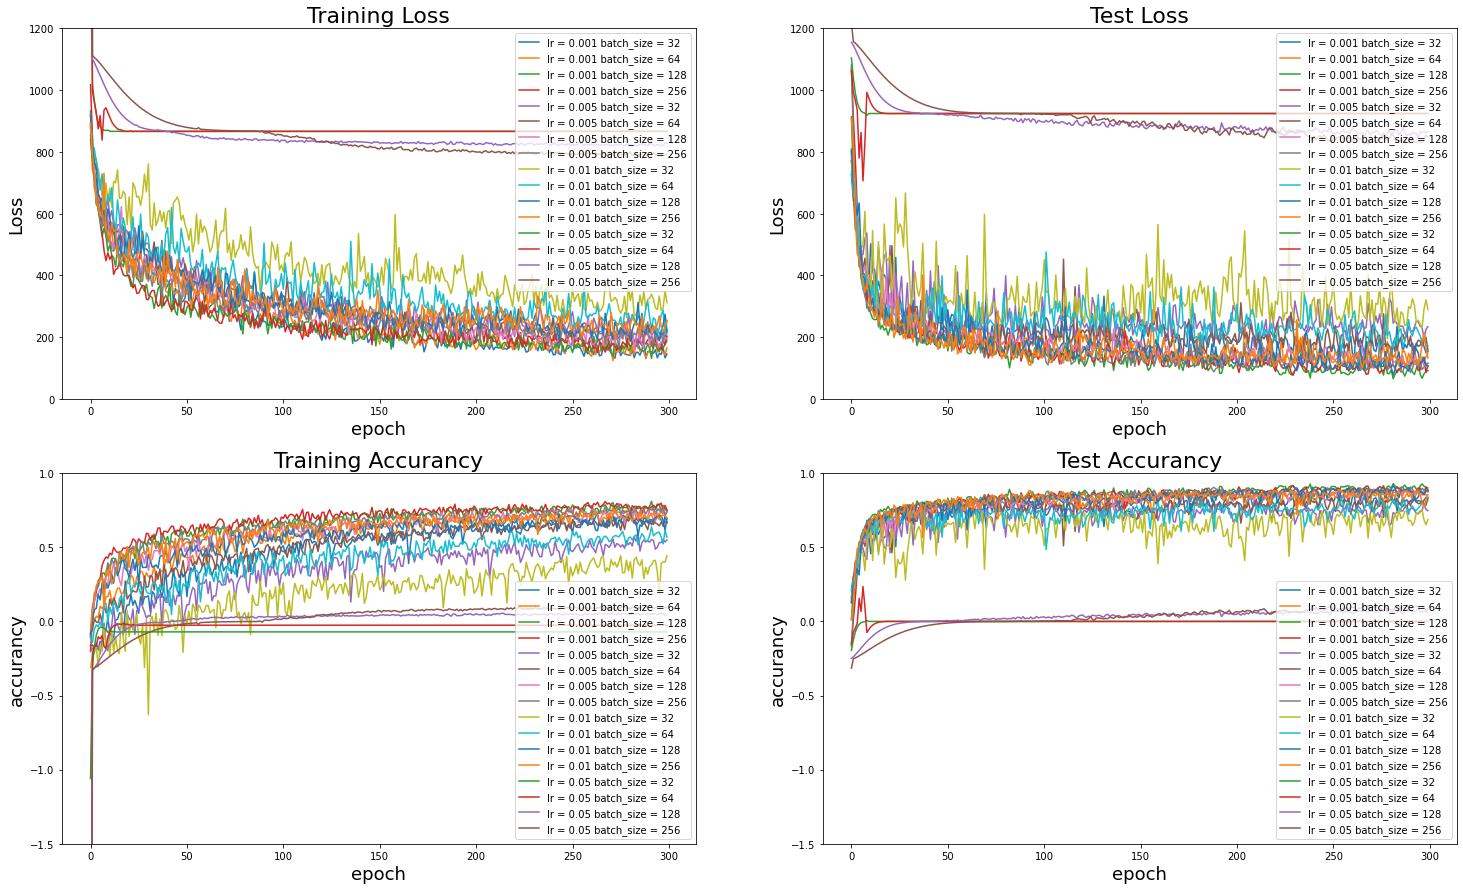

<Figure size 1800x1080 with 0 Axes>

In [33]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Training Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1200])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1200])

ax3.set_title("Training Accurancy", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("accurancy", fontsize=18)
ax3.legend()
ax3.set_ylim([-1.5,1])

ax4.set_title("Test Accurancy", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("accurancy", fontsize=18)
ax4.legend()
ax4.set_ylim([-1.5,1])

plt.show()

In [34]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

0.6668051355433261
0.7430033581380436
0.7531728873659019
0.7477978848693745
0.5504221077086405
0.6639225813687207
0.7388444315013253
0.7410419665013755
0.4418975064879319
0.5684907090370219
0.6931485760324144
0.6987647024704237
-0.07066840611032786
-0.025462278678126064
0.043310120981440554
0.09170486631678566
___________________

0.833208851660308
0.8390952759571373
0.9001450090650501
0.8826586467036913
0.7469113225177884
0.8285629802030018
0.8745549692747334
0.875101324032448
0.6869045894796137
0.8129846842267932
0.8854519186452536
0.8557970781633374
-4.7585494769464276e-05
-5.483424765251321e-05
0.06316310045348938
0.0819799278691693
___________________

145.76874323324725
166.20804526589134
188.33858455311167
204.0115141435103
225.31183528900146
202.42751450972125
194.7938393679532
212.68835033069956
311.5615736354481
253.01861763000488
219.58684401078656
255.0890093716708
866.5232401761142
866.7082047895951
828.2090939608487
791.4516934481534
___________________

154.1839752197265

### 2 best models

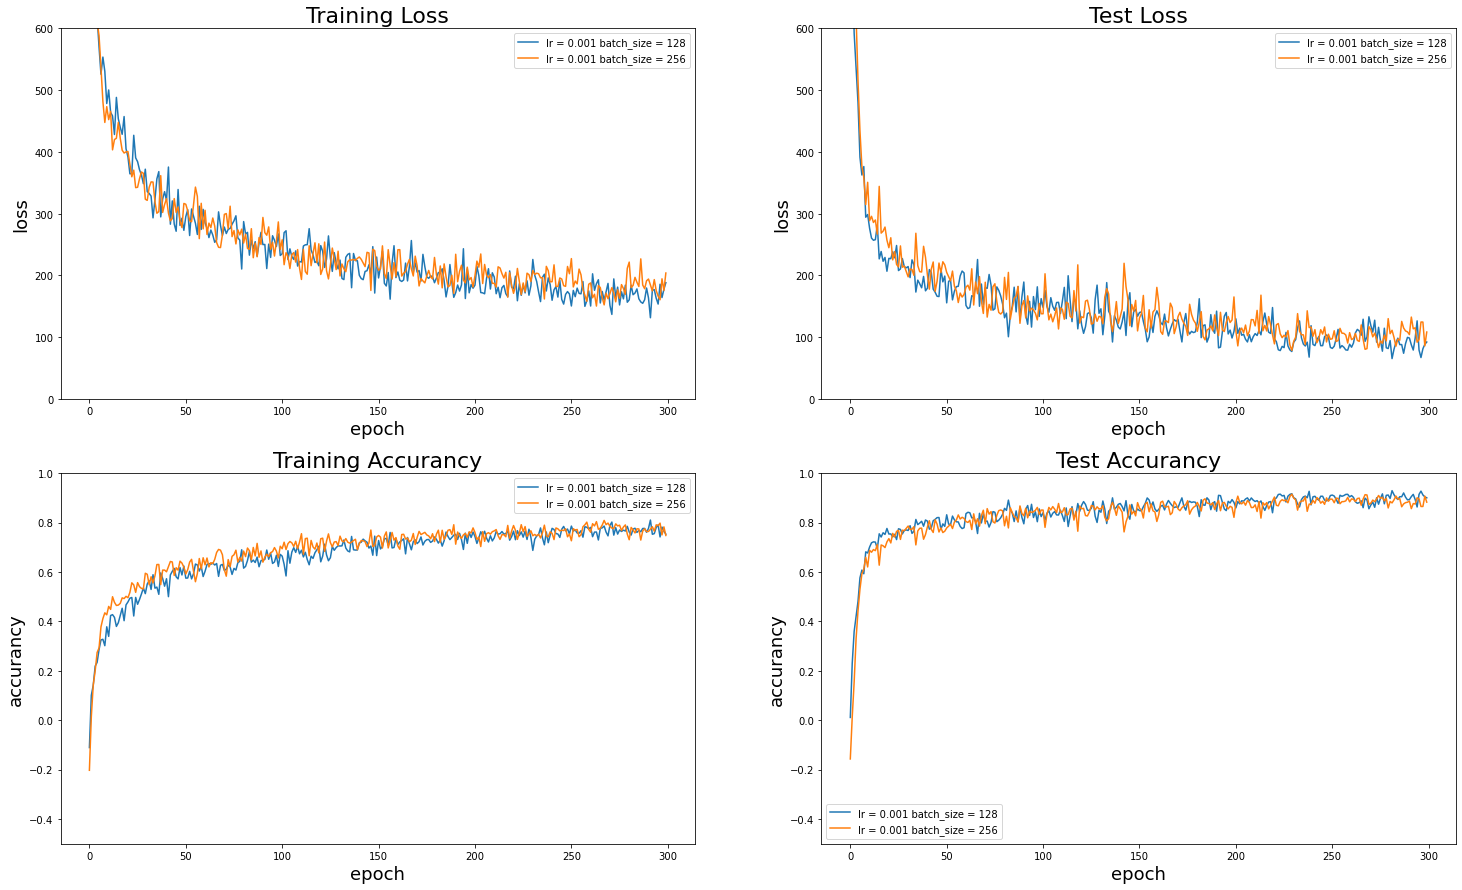

<Figure size 432x288 with 0 Axes>

In [35]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Training Loss", fontsize=22)
ax1.plot(train_losses_all[2],label="lr = 0.001 batch_size = 128")
ax1.plot(train_losses_all[3],label="lr = 0.001 batch_size = 256")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 600])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[2],label="lr = 0.001 batch_size = 128")
ax2.plot(test_losses_all[3],label="lr = 0.001 batch_size = 256")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 600])

ax3.set_title("Training Accurancy", fontsize=22)
ax3.plot(train_accs_all[2],label="lr = 0.001 batch_size = 128")
ax3.plot(train_accs_all[3],label="lr = 0.001 batch_size = 256")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("accurancy", fontsize=18)
ax3.legend()
ax3.set_ylim([-0.5,1])

ax4.set_title("Test Accurancy", fontsize=22)
ax4.plot(test_accs_all[2],label="lr = 0.001 batch_size = 128")
ax4.plot(test_accs_all[3],label="lr = 0.001 batch_size = 256")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("accurancy", fontsize=18)
ax4.legend()
ax4.set_ylim([-0.5,1])
plt.show()

## 4.2. Training

In [9]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=704, shuffle=False)

In [11]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1000
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/caco_maccs_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 936.3020907315341, Accuracy: -0.1180419600794773
Test Avg. loss: 1077.9022216796875, Accuracy: -0.040939219721267905
################## EPOCH 2 ##################
Train Avg. loss: 766.8198727694424, Accuracy: 0.10551877382244584
Test Avg. loss: 954.8182373046875, Accuracy: 0.07792404279829224
################## EPOCH 3 ##################
Train Avg. loss: 712.5593983043324, Accuracy: 0.16794674908259935
Test Avg. loss: 904.6489868164062, Accuracy: 0.12637291044901777
################## EPOCH 4 ##################
Train Avg. loss: 626.8217489069158, Accuracy: 0.24156138097269564
Test Avg. loss: 874.5675659179688, Accuracy: 0.15542277024695106
################## EPOCH 5 ##################
Train Avg. loss: 564.1037958318537, Accuracy: 0.27916200607570624
Test Avg. loss: 886.4614868164062, Accuracy: 0.14393682472360692
################## EPOCH 6 ##################
Train Avg. loss: 524.7326646284623, Accuracy: 0.30591775550187195


Train Avg. loss: 292.95335214788264, Accuracy: 0.5987014563318749
Test Avg. loss: 537.1181030273438, Accuracy: 0.48130060439653033
################## EPOCH 49 ##################
Train Avg. loss: 292.0006727738814, Accuracy: 0.5767579682204281
Test Avg. loss: 561.9353637695312, Accuracy: 0.45733429729922015
################## EPOCH 50 ##################
Train Avg. loss: 297.8092658303001, Accuracy: 0.6178640790224105
Test Avg. loss: 498.44622802734375, Accuracy: 0.5186463236463795
################## EPOCH 51 ##################
Train Avg. loss: 273.1380327398127, Accuracy: 0.6100995791404805
Test Avg. loss: 466.2579040527344, Accuracy: 0.5497308123679914
################## EPOCH 52 ##################
Train Avg. loss: 290.27195046164775, Accuracy: 0.5806481025123621
Test Avg. loss: 474.6451721191406, Accuracy: 0.5416312175963257
################## EPOCH 53 ##################
Train Avg. loss: 279.6617965698242, Accuracy: 0.6208589555274799
Test Avg. loss: 580.3917236328125, Accuracy: 0.439

Train Avg. loss: 240.44050979614258, Accuracy: 0.6940477044039081
Test Avg. loss: 485.609375, Accuracy: 0.5310429996819312
################## EPOCH 96 ##################
Train Avg. loss: 251.3693840720437, Accuracy: 0.6429840340104717
Test Avg. loss: 467.0072937011719, Accuracy: 0.5490072105344216
################## EPOCH 97 ##################
Train Avg. loss: 235.00604005293414, Accuracy: 0.6575982278886158
Test Avg. loss: 491.4059143066406, Accuracy: 0.5254452083971802
################## EPOCH 98 ##################
Train Avg. loss: 223.27765759554777, Accuracy: 0.6910606856411713
Test Avg. loss: 470.28375244140625, Accuracy: 0.545843080464451
################## EPOCH 99 ##################
Train Avg. loss: 240.93030964244497, Accuracy: 0.6686078631892592
Test Avg. loss: 500.83984375, Accuracy: 0.5163347666661501
################## EPOCH 100 ##################
Train Avg. loss: 230.28872299194336, Accuracy: 0.6924903717426354
Test Avg. loss: 443.9161071777344, Accuracy: 0.57130650853849

Train Avg. loss: 186.95039853182706, Accuracy: 0.7336864649247492
Test Avg. loss: 528.9080200195312, Accuracy: 0.489229079429205
################## EPOCH 143 ##################
Train Avg. loss: 186.70165183327416, Accuracy: 0.737066795814854
Test Avg. loss: 535.8033447265625, Accuracy: 0.4825702402135913
################## EPOCH 144 ##################
Train Avg. loss: 192.43319216641513, Accuracy: 0.7442495484170787
Test Avg. loss: 507.607421875, Accuracy: 0.5097992646496348
################## EPOCH 145 ##################
Train Avg. loss: 213.8573542508212, Accuracy: 0.6859637198040569
Test Avg. loss: 563.4918212890625, Accuracy: 0.4558312346491392
################## EPOCH 146 ##################
Train Avg. loss: 209.49872901222923, Accuracy: 0.7149428045139601
Test Avg. loss: 486.3614807128906, Accuracy: 0.530316651115869
################## EPOCH 147 ##################
Train Avg. loss: 201.4082541032271, Accuracy: 0.7250793864293703
Test Avg. loss: 531.5051879882812, Accuracy: 0.486721

Train Avg. loss: 196.78190820867366, Accuracy: 0.733418777393452
Test Avg. loss: 541.368896484375, Accuracy: 0.47719559081861596
################## EPOCH 190 ##################
Train Avg. loss: 192.35639814897016, Accuracy: 0.7425011414752393
Test Avg. loss: 526.85205078125, Accuracy: 0.49121459785695454
################## EPOCH 191 ##################
Train Avg. loss: 179.4344253540039, Accuracy: 0.736874281710056
Test Avg. loss: 514.6209106445312, Accuracy: 0.5030263048459063
################## EPOCH 192 ##################
Train Avg. loss: 197.66475226662376, Accuracy: 0.7179546342337353
Test Avg. loss: 539.15185546875, Accuracy: 0.4793365356669864
################## EPOCH 193 ##################
Train Avg. loss: 195.55283425071022, Accuracy: 0.7462460588647901
Test Avg. loss: 604.6946411132812, Accuracy: 0.41604140517217103
################## EPOCH 194 ##################
Train Avg. loss: 208.09950291026723, Accuracy: 0.7149073067990538
Test Avg. loss: 473.177734375, Accuracy: 0.543048

Train Avg. loss: 164.86268615722656, Accuracy: 0.7642468343754654
Test Avg. loss: 520.01025390625, Accuracy: 0.4978218537646911
################## EPOCH 237 ##################
Train Avg. loss: 185.61532696810636, Accuracy: 0.7474020502831616
Test Avg. loss: 567.53466796875, Accuracy: 0.45192699107179135
################## EPOCH 238 ##################
Train Avg. loss: 148.28314590454102, Accuracy: 0.7807984615682092
Test Avg. loss: 571.3198852539062, Accuracy: 0.44827161995764087
################## EPOCH 239 ##################
Train Avg. loss: 181.2865947376598, Accuracy: 0.7605012191298866
Test Avg. loss: 538.4074096679688, Accuracy: 0.48005547826689887
################## EPOCH 240 ##################
Train Avg. loss: 168.53806374289772, Accuracy: 0.7704928622831239
Test Avg. loss: 509.00921630859375, Accuracy: 0.5084455754793009
################## EPOCH 241 ##################
Train Avg. loss: 212.1801116249778, Accuracy: 0.7404423970475573
Test Avg. loss: 542.0872192382812, Accuracy: 0

Train Avg. loss: 206.2057252363725, Accuracy: 0.7469572932320091
Test Avg. loss: 485.8482971191406, Accuracy: 0.5308122573868195
################## EPOCH 284 ##################
Train Avg. loss: 206.62762520530006, Accuracy: 0.7240660418805309
Test Avg. loss: 515.8004150390625, Accuracy: 0.5018872231470908
################## EPOCH 285 ##################
Train Avg. loss: 171.00763633034447, Accuracy: 0.7627996175288161
Test Avg. loss: 535.5017700195312, Accuracy: 0.4828614381876353
################## EPOCH 286 ##################
Train Avg. loss: 175.91464233398438, Accuracy: 0.77388399737759
Test Avg. loss: 536.39794921875, Accuracy: 0.4819960642116854
################## EPOCH 287 ##################
Train Avg. loss: 160.80416280573064, Accuracy: 0.764883743115285
Test Avg. loss: 490.052001953125, Accuracy: 0.5267527345145033
################## EPOCH 288 ##################
Train Avg. loss: 152.4066283486106, Accuracy: 0.786844727110903
Test Avg. loss: 498.3941345214844, Accuracy: 0.518696

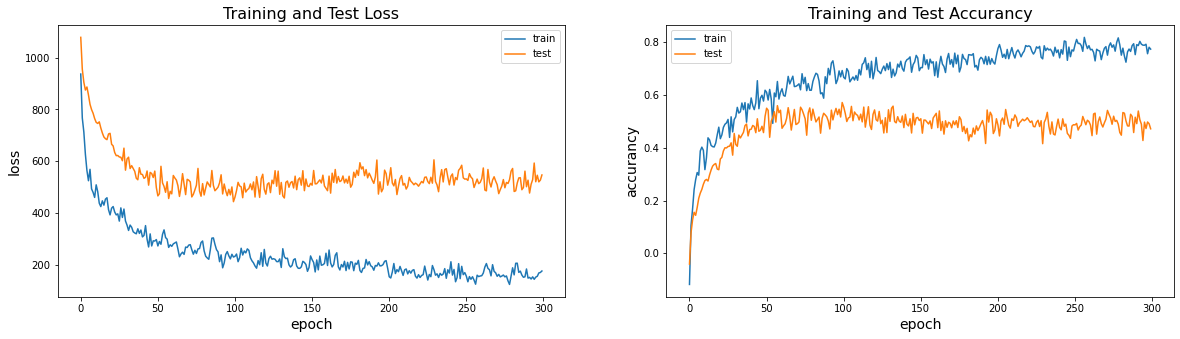

<Figure size 1440x360 with 0 Axes>

In [12]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Training and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.legend()

ax2.set_title("Training and Test Accurancy", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("accurancy", fontsize=14)
ax2.legend()
plt.show()

In [15]:
model = FCNN()
model.load_state_dict(torch.load('../../models/caco_maccs_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 9.952043
MSE: 443.9161
RMSE: 21.069317
R2 Square 0.5713065085384971 

